# Data Analyst (Risk) - Cloudwalk Case
## Candidate: Bruno Vieira

**Notebook Structure**
1. Imports: Include library and modules
2. EDA: Exploratory analysis of the provided data.
3. Anti-Fraud Solution: Approaches to detect and prevent fraud.
4. Answers: Answers to the questions made in the instructions pdf.

## Imports

In [1]:
import time
import pandas as pd
import numpy as np
from datetime import datetime

## Data viz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Ensuring that the plots are displayed in github
import plotly.io as pio
pio.renderers.default = "png"

# Stats
from scipy.interpolate import interp1d
from statsmodels.stats.proportion import proportions_ztest

# ML
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, f1_score, precision_score, accuracy_score,\
    make_scorer, roc_auc_score, roc_curve, ConfusionMatrixDisplay, confusion_matrix
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from imblearn.under_sampling import RandomUnderSampler


In [2]:
# Taking a look at the data
data = pd.read_csv('transactional-sample.csv')

data.head(3)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False


## EDA

### Data analysis

#### Dataset Structure

**Key observations**
* The dataset has **3199** transactions with **8** columns.
* The only column with missing values is **`device_id`** (*830 missing values*).
* The dataset has no duplicated values
* The transactions happend between **2019-11-01 01:27:15** and **2019-12-01 23:16:32**

**Column descriptions:**

* **`transaction_id`**: Unique identifier for each transaction (*int64*).
* **`merchant_id`**: Unique identifier for each merchant (*int64*).
* **`user_id`**: Unique identifier for each customer (*int64*).
* **`card_number`**: The card number used for the transaction (*object*).
* **`transaction_date`**: The date when the transaction ocurred (*object*).
* **`transaction_amount`**: The amount spent in the transaction (*float64*).
* **`device_id`**: Unique identifier of the device used for the transaction (*float64*).
* **`has_cbk`**: Boolean flag indicating if the transaction resulted in a chargeback (*bool*).

**Closer look in the identification columns:**

* **`merchant_id`**: **1756** unique merchants.
* **`user_id`**: **2704** unique users.
* **`device_id`** **1996** unique devices.

**Closer look in the fraud column: `has_cbk`**

* **2080** (*~87.8%*) transactions flagged as non-fraud chargeback.
* **391** (*~12.2%*) transactions flagged fraud chargeback.


In [3]:
print(f"Number of transactions: {len(data)}.")
print('-'*150)
print(f"Columns in the dataset {list(data.columns)}.")

Number of transactions: 3199.
------------------------------------------------------------------------------------------------------------------------------------------------------
Columns in the dataset ['transaction_id', 'merchant_id', 'user_id', 'card_number', 'transaction_date', 'transaction_amount', 'device_id', 'has_cbk'].


In [4]:
data.info() # Taking a look general informations about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      3199 non-null   int64  
 1   merchant_id         3199 non-null   int64  
 2   user_id             3199 non-null   int64  
 3   card_number         3199 non-null   object 
 4   transaction_date    3199 non-null   object 
 5   transaction_amount  3199 non-null   float64
 6   device_id           2369 non-null   float64
 7   has_cbk             3199 non-null   bool   
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 178.2+ KB


In [5]:
data.isna().sum() # Checking for missing values

transaction_id          0
merchant_id             0
user_id                 0
card_number             0
transaction_date        0
transaction_amount      0
device_id             830
has_cbk                 0
dtype: int64

In [6]:
data.duplicated().sum() # Checking for duplicates

np.int64(0)

In [7]:
# It looks like the date column is a Object type, let's transform it to a datetime.
data['transaction_date'] = pd.to_datetime(data['transaction_date'], format="%Y-%m-%dT%H:%M:%S.%f")

print(f"Data type of the transaction_date column after transformation: {data['transaction_date'].dtype}")

print(f"First day of transaction sample: {data['transaction_date'].min()}.")
print(f"Last day of transaction sample: {data['transaction_date'].max()}.")

Data type of the transaction_date column after transformation: datetime64[ns]
First day of transaction sample: 2019-11-01 01:27:15.811098.
Last day of transaction sample: 2019-12-01 23:16:32.812632.


In [8]:
np.round(data['has_cbk'].value_counts(normalize=True), 3) # Checking the proportion of fraud transactions

has_cbk
False    0.878
True     0.122
Name: proportion, dtype: float64

has_cbk
False    2808
True      391
Name: count, dtype: int64


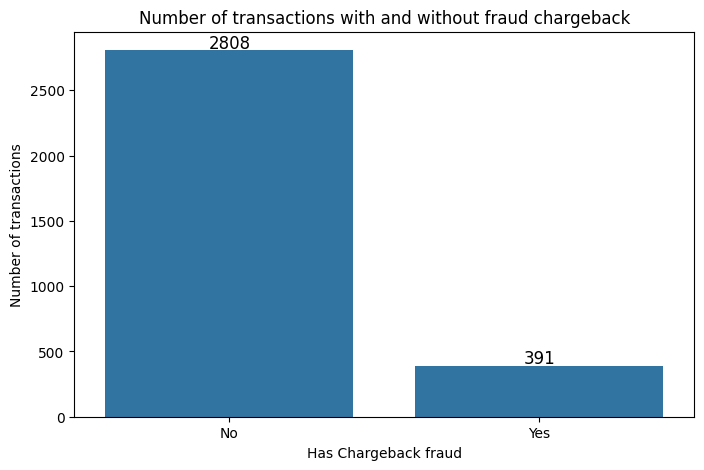

In [9]:
print(data['has_cbk'].value_counts())

fig = plt.figure(figsize=(8, 5))
ax = sns.barplot(x=data['has_cbk'], y=data['has_cbk'].value_counts())

plt.title('Number of transactions with and without fraud chargeback')
plt.ylabel('Number of transactions')
plt.xlabel('Has Chargeback fraud')

plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# Adding the number of transactions in each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.show()

In [10]:
# checking for unique values in identification columns
for col in ['merchant_id', 'user_id', 'device_id']:
    print(f"{col}: {data[col].nunique()} unique values.")

merchant_id: 1756 unique values.
user_id: 2704 unique values.
device_id: 1996 unique values.


#### Statistical Analysis

**`transaction_amount` Summary statisticas**:

* **Count**: The dataset contains **3199** transactions
* **Mean**: The average transaction amount is **$767.81**
* **Std dev**: A high standard deviation (**$889.10**) indicates significant variability in transaction amounts.
* **Min**: The smallest transaction recorded is **$1.22**
* **25% (First Quartile)**: 25% of transactions are below **$205.23**.
* **50% (Median)**: The middle transaction amount is **$415.94**.
* **75% (Third Quartile)**: 75% of transactions are below **$981.68**.
* **Max**: The largest transaction recorded is **$4097.21**.

In [11]:
print(data['transaction_amount'].describe()) # Taking a look at the basic statistics of the transaction amount column

count    3199.000000
mean      767.812904
std       889.095904
min         1.220000
25%       205.235000
50%       415.940000
75%       981.680000
max      4097.210000
Name: transaction_amount, dtype: float64


**Correlations**

The heatmap bellow visualizes the correlation between various features in the dataset. Here are the key insights:

- **`transaction_date` has a strong negative correlation (-0.94) with `transaction_id`**  
  This likely suggests that `transaction_id` is sequential and increases over time, leading to an inverse relationship with transaction dates.  
  **This is not so relevant for us**, as it does not provide meaningful insights into chargeback fraud.

- **`has_cbk` (chargeback indicator) has the highest correlation with `transaction_amount` (0.29)**  
  Fraudulent transactions tend to have higher amounts, which aligns with our previous findings that fraud-related transactions have a higher mean value.  
  **This is highly relevant, as it suggests that high-value transactions may have a greater likelihood of being fraudulent.**

- **Other features have weak correlations with each other**  
  Most values are close to 0, indicating little to no linear relationship between these variables.  
  **This is not very relevant, as weak correlations suggest these features do not directly impact chargeback fraud detection.**

- **Slight positive correlation (0.11) between `transaction_date` and `has_cbk`**  
  This may suggest that fraud patterns fluctuate over time, but further investigation is needed.  
  **This could be relevant depending on whether fraud occurs more frequently at certain times. It may indicate seasonality in fraudulent transactions.**


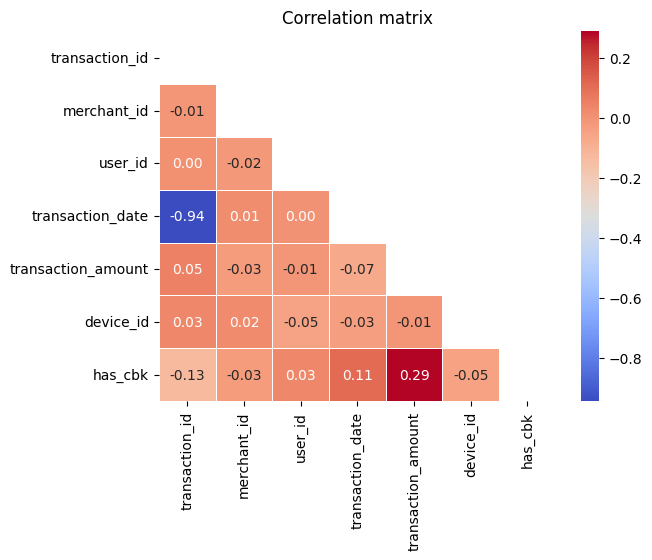

In [12]:
sns.heatmap(
    data.drop(columns=['card_number']).corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    mask=np.triu(data.drop(columns=['card_number']).corr())
)

plt.title('Correlation matrix')

plt.show()

#### Distribution and pattern analysis

##### Diving deeper: **`transaction_amount`**

**Mean comparison**: Comparison of the mean transaction amount across all transactions, as well as segmented by fraudulent and non-fraudulent transactions.

```
All transactions: 767.813
Non-fraudulent transactions: 672.324
Fraudulent transactions: 1453.572
```
**Key Insights**:
* Fraudulent transactions have a significantly higher mean transaction amount (**$1453.57**) compared to non-fraudulent transactions (**$672.32**).
* The overall mean transaction amount is **$767.81**, indicating that fraud cases may be skewing the overall average upwards.

**Median comparison**: Comparison of median transaction amount accross all transactions, fraudulent, and non-fraudulent transactions.

```
All transactions: 415.94
Non-fraudulent transactions: 360.315
Fraudulent transactions: 999.47
```
**Key Insights**:
* The median transaction amount for fraudulent transactions (**$999.47**) is much higher than for non-fraudulent transactions (**$360.32**), reinforcing the pattern seen in the mean comparison.
* The overall median transaction amount is (**$415.94**), which is lower than the mean, suggesting a right-skewed distribution.


**Standard Deviation comparison**: Comparison of standard deviation accross all transactions, fraudulent, and non-fraudulent transactions.

```
All transactions: 889.096
Non-fraudulent transactions: 797.464
Fraudulent transactions: 1169.491
```
**Key Insights**:
* Fraudulent transactions exhibit a much higher standard deviation (**$1169.49**), indicating greater variability in fraudulent transaction amounts.
* Non-fraudulent transactions have a lower standard deviation (**$797.46**), suggesting more consistency in legitimate spending patterns.
* The overall standard deviation is **$889.10**, again reflecting the impact of fraudulent transactions on the dataset's variability.

**Possible suspicious behaviours:**
* Fraudulent transactions tend to have higher amounts.
* High variability may indicate attempts to avoid predictable patterns, making automated detection more challenging.

In [13]:
fraudulent_transactions = data[data['has_cbk']==True]
non_fraudulent_transactions = data[data['has_cbk']==False]

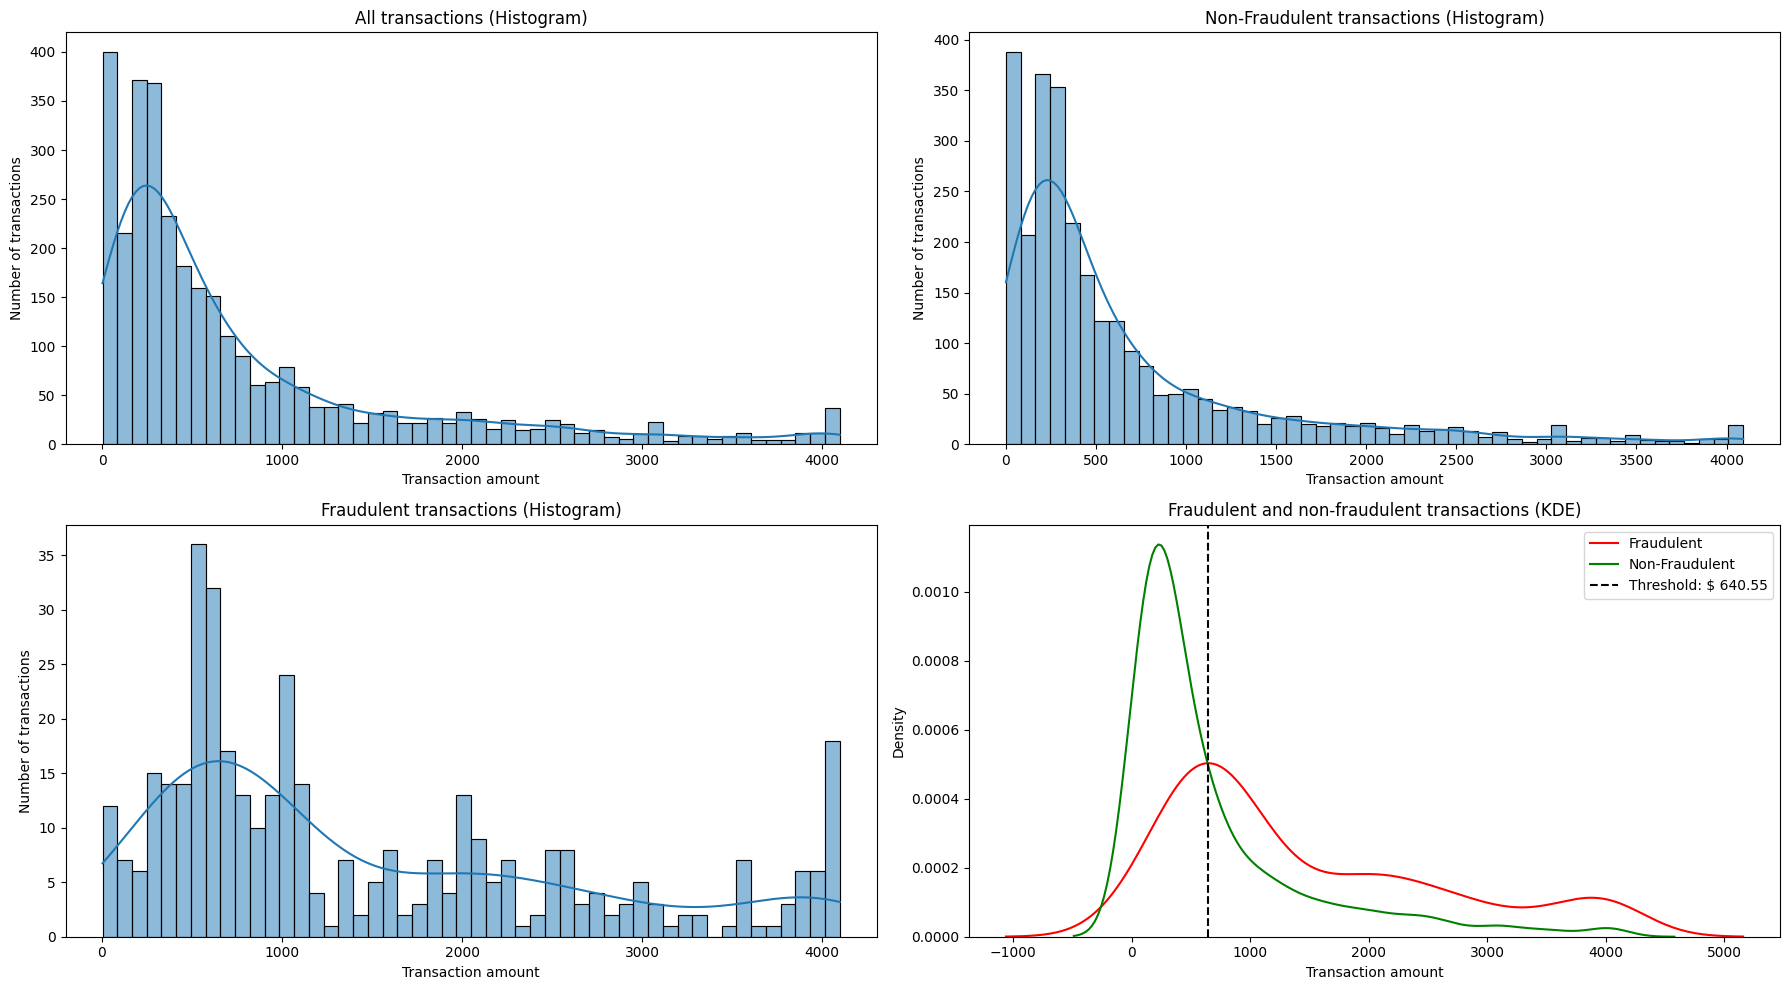

In [14]:
# Creating a function to plot the distribution of the transaction amount
def plot_transaction_amount_dist(data, ax=None, figsize=(8, 5), type='hist', color=None, label=None):
    if type == 'hist':
        sns.histplot(data['transaction_amount'], bins=50, kde=True, ax=ax, color=color)
    elif type == 'kde':
        sns.kdeplot(data['transaction_amount'], ax=ax, color=color, label=label)


    #sns.histplot(data['transaction_amount'], bins=50, kde=True, ax=ax)

# Plotting the distribution of the transaction amount
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Plotting the distribution of the transaction amount for all transactions
plot_transaction_amount_dist(data, ax=axes[0, 0])
axes[0, 0].set_title("All transactions (Histogram)")
axes[0, 0].set_xlabel("Transaction amount")
axes[0, 0].set_ylabel("Number of transactions")

# Plotting the distribution of the transaction amount for non-fraudulent transactions
plot_transaction_amount_dist(non_fraudulent_transactions, ax=axes[0, 1])
axes[0, 1].set_title("Non-Fraudulent transactions (Histogram)")
axes[0, 1].set_xlabel("Transaction amount")
axes[0, 1].set_ylabel("Number of transactions")

# Plotting the distribution of the transaction amount for fraudulent transactions
plot_transaction_amount_dist(fraudulent_transactions, ax=axes[1, 0])
axes[1, 0].set_title("Fraudulent transactions (Histogram)")
axes[1, 0].set_xlabel("Transaction amount")
axes[1, 0].set_ylabel("Number of transactions")

plot_transaction_amount_dist(fraudulent_transactions, ax=axes[1, 1], type='kde', label = 'Fraudulent', color='red')
plot_transaction_amount_dist(non_fraudulent_transactions, ax=axes[1, 1], type='kde', color='green', label='Non-Fraudulent')
axes[1, 1].set_title("Fraudulent and non-fraudulent transactions (KDE)")
axes[1, 1].set_xlabel("Transaction amount")
axes[1, 1].set_ylabel("Density")

# Extrair os dados das curvas KDE
kde_fraud = axes[1, 1].get_lines()[0].get_data()  # Curva KDE das transações fraudulentas (vermelha)
kde_non_fraud = axes[1, 1].get_lines()[1].get_data()  # Curva KDE das transações não fraudulentas (verde)

# Interpolar as curvas KDE para encontrar o ponto de interseção
f_fraud = interp1d(kde_fraud[0], kde_fraud[1], bounds_error=False, fill_value=0)
f_non_fraud = interp1d(kde_non_fraud[0], kde_non_fraud[1], bounds_error=False, fill_value=0)

# Definir o intervalo de x_values apenas para valores positivos e onde ambas as curvas têm densidade > 0
x_values = np.linspace(max(0, kde_fraud[0].min(), kde_non_fraud[0].min()),
                       max(kde_fraud[0].max(), kde_non_fraud[0].max()),
                       1000)
valid_range = (x_values > 0) & (f_fraud(x_values) > 0) & (f_non_fraud(x_values) > 0)
x_values_valid = x_values[valid_range]

# Calcular a diferença apenas no intervalo válido
diff = f_fraud(x_values_valid) - f_non_fraud(x_values_valid)
intersection_index = np.argmin(np.abs(diff))
intersection_x = x_values_valid[intersection_index]

# Adicionar uma linha vertical no gráfico para marcar o threshold
axes[1, 1].axvline(intersection_x, color='black', linestyle='--', label=f'Threshold: $ {intersection_x:.2f}')
axes[1, 1].legend()
plt.tight_layout()
plt.show()

In [15]:
# Getting some statistics about the fraudulent transactions
print("Mean comparison between all transactions, fraudulent and non-fraudulent transactions:")
print(f"All transactions: {round(data['transaction_amount'].mean(), 3)}")
print(f"Non-fraudulent transactions: {round(non_fraudulent_transactions['transaction_amount'].mean(), 3)}")
print(f"Fraudulent transactions: {round(fraudulent_transactions['transaction_amount'].mean(), 3)}")

print("-"*100)

print("Standard deviation comparison between all transactions, fraudulent and non-fraudulent transactions:")
print(f"All transactions: {round(data['transaction_amount'].std(), 3)}")
print(f"Non-fraudulent transactions: {round(non_fraudulent_transactions['transaction_amount'].std(), 3)}")
print(f"Fraudulent transactions: {round(fraudulent_transactions['transaction_amount'].std(), 3)}")

print("-"*100)

print("Median comparison between all transactions, fraudulent and non-fraudulent transactions:")
print(f"All transactions: {round(data['transaction_amount'].median(), 3)}")
print(f"Non-fraudulent transactions: {round(non_fraudulent_transactions['transaction_amount'].median(), 3)}")
print(f"Fraudulent transactions: {round(fraudulent_transactions['transaction_amount'].median(), 3)}")

Mean comparison between all transactions, fraudulent and non-fraudulent transactions:
All transactions: 767.813
Non-fraudulent transactions: 672.324
Fraudulent transactions: 1453.572
----------------------------------------------------------------------------------------------------
Standard deviation comparison between all transactions, fraudulent and non-fraudulent transactions:
All transactions: 889.096
Non-fraudulent transactions: 797.464
Fraudulent transactions: 1169.491
----------------------------------------------------------------------------------------------------
Median comparison between all transactions, fraudulent and non-fraudulent transactions:
All transactions: 415.94
Non-fraudulent transactions: 360.315
Fraudulent transactions: 999.47


/tmp/ipykernel_23386/3316349999.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



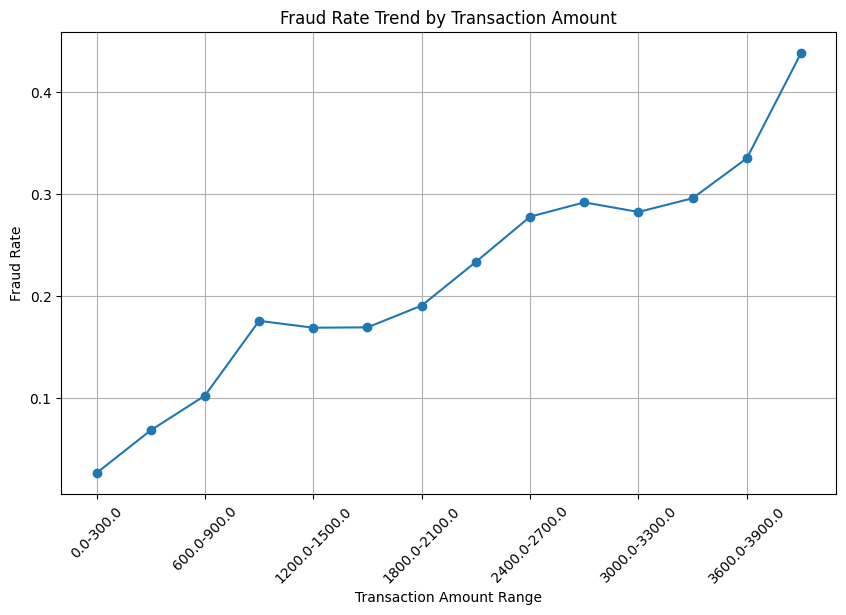

In [16]:
# Increasing bin size to reduce variation in fraud rates
bins = np.arange(0, data['transaction_amount'].max() + 300, 300)  # Creating bins with 300-unit intervals
labels = [f'{i}-{i+300}' for i in bins[:-1]]  # Creating labels for each bin range

# Adding a new column with transaction amount ranges
data['amount_range'] = pd.cut(data['transaction_amount'], bins=bins, labels=labels, include_lowest=True)

# Calculating the fraud rate for each transaction amount range
fraud_rate = data.groupby('amount_range')['has_cbk'].mean()

# Applying a moving average to smooth out the fraud rate trend
window_size = 3  # Defining the window size for the moving average
fraud_rate_smoothed = fraud_rate.rolling(window=window_size, min_periods=1).mean()

# Plotting the fraud rate trend
plt.figure(figsize=(10, 6))
fraud_rate_smoothed.plot(kind='line', marker='o')
plt.title('Fraud Rate Trend by Transaction Amount')
plt.xlabel('Transaction Amount Range')
plt.ylabel('Fraud Rate')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

##### Diving deeper:  **`user_id`**

**Top 3** users with the most total transactions

```
User ID: 11750 - Transactions: 31
User ID: 91637 - Transactions: 22
User ID: 79054 - Transactions: 17
```

**Top 3** users with the most fraudulent transactions
```
User ID: 11750 - Fraudulent transactions: 25
User ID: 91637 - Fraudulent transactions: 19
User ID: 79054 - Fraudulent transactions: 15
```
**Key Insights:**
* The user with the most transactions (11750) also has the highest number of fraudulent transactions (25), suggesting suspicious activity.
* Users 91637 and 79054 follow a similar trend, with 19 and 15 fraudulent transactions, respectively.
* Fraudulent transactions appear concentrated among certain users, which could indicate organized fraudulent behavior.

**Top 3** users with the highest fraud rate (that isn't 100%)
```
User ID: 78262 - Fraud rate: 0.92 - Total transactions: 13
User ID: 79054 - Fraud rate: 0.88 - Total transactions: 17
User ID: 91637 - Fraud rate: 0.86 - Total transactions: 22
```
**Key Insights:**
* 120 users have 100% fraudulent transactions
* Users 78262, 79054 and 91637 has an extremely high fraud rate (92%, 88% and 86% respectively), indicating potential fraudsters.
* A high fraud rate in combination with a high number of transactions could be a strong indicator of fraudulent activity.

**Possible suspicious patterns:**
* Some fraudsters are repeat offenders and tend to make a high number of transactions.
* The results suggest that fraudsters tend to carry out multiple transactions in a sequence (It is possible that fraudsters are testing cards or making small transactions before conducting larger ones).

**Recommendations:**
* Check the user's fraud history. If the user has a record of one or more fraudulent transactions, we should monitor them closely.
* Be cautious of multiple transactions in a sequence. Consider implementing security measures to temporarily block users after 3 or more transactions within a short period of time.

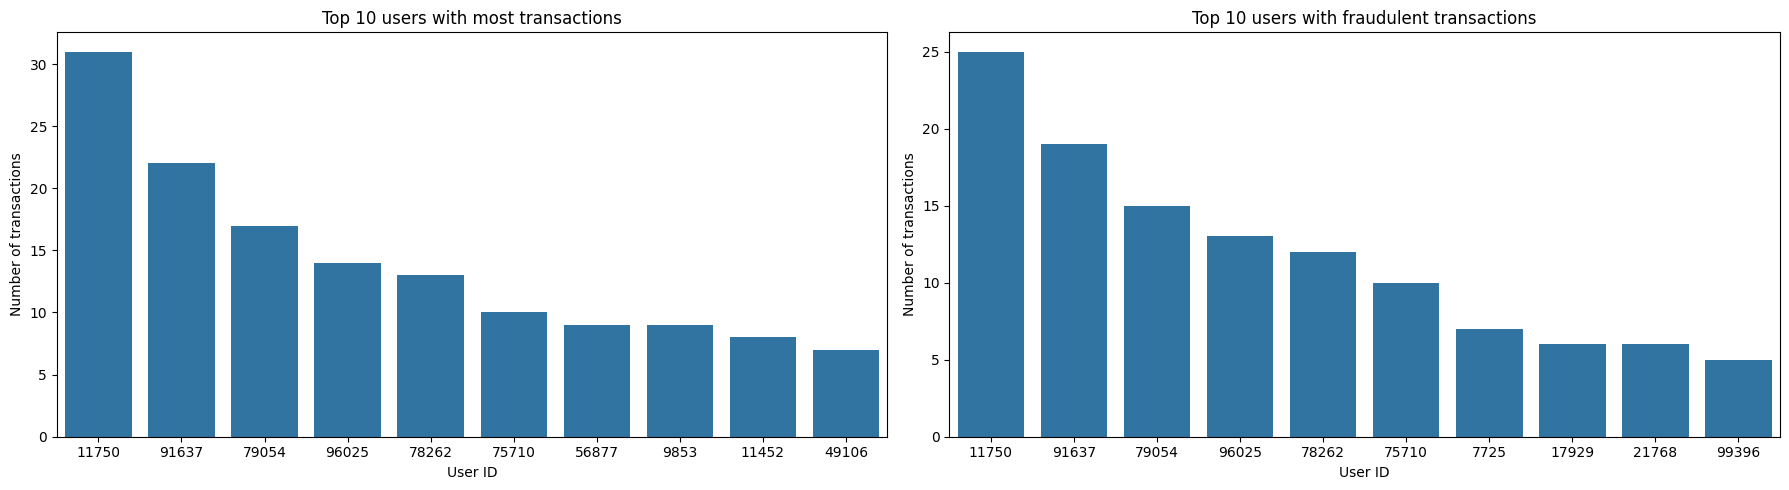

In [17]:
users = data['user_id'].value_counts().sort_values(ascending=False)
users_fraud = fraudulent_transactions['user_id'].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(x=users.head(10).index, y=users.head(10).values, order=users.head(10).index, ax=axes[0])
axes[0].set_title("Top 10 users with most transactions")
axes[0].set_xlabel("User ID")
axes[0].set_ylabel("Number of transactions")

sns.barplot(x=users_fraud.head(10).index, y=users_fraud.head(10).values, order=users_fraud.head(10).index, ax=axes[1])
axes[1].set_title("Top 10 users with fraudulent transactions")
axes[1].set_xlabel("User ID")
axes[1].set_ylabel("Number of transactions")

plt.tight_layout()
plt.show()

In [18]:
users_fraud = fraudulent_transactions['user_id'].value_counts().sort_values(ascending=False)

print("Top 3 users with more transactions:")
for i, j in zip(users.index[:3], users.values[:3]):
    print(f"User ID: {i} - Number of transactions: {j}")

print("-"*50)

print("Top 3 users with more fraudulent transactions:")
for i, j in zip(users_fraud.index[:3], users_fraud.values[:3]):
    print(f"User ID: {i} - Number of fraudulent transactions: {j}")

Top 3 users with more transactions:
User ID: 11750 - Number of transactions: 31
User ID: 91637 - Number of transactions: 22
User ID: 79054 - Number of transactions: 17
--------------------------------------------------
Top 3 users with more fraudulent transactions:
User ID: 11750 - Number of fraudulent transactions: 25
User ID: 91637 - Number of fraudulent transactions: 19
User ID: 79054 - Number of fraudulent transactions: 15


In [19]:
# Creating a new dataframe with the number of transactions and the number of fraudulent transactions for each user
users_transactions = users.to_frame().merge(users_fraud.to_frame().reset_index(), on='user_id', how='left').fillna(0).rename(columns={
    'index': 'user_id', 'count_x': 'total_transactions', 'count_y': 'fraud'
    })

users_transactions['fraud'] = users_transactions['fraud'].astype(int)

# Calculating the fraud rate for each user
users_transactions['fraud_rate'] = users_transactions['fraud'] / users_transactions['total_transactions']
users_transactions.sort_values(by='fraud_rate', ascending=False, inplace=True)

# Total number of users that all transactions are fraudulent
print(f"Users with only fraudulent transactions: {len(users_transactions[users_transactions['fraud_rate'] == 1])}")

Users with only fraudulent transactions: 120


In [20]:
not_100 = users_transactions[users_transactions['fraud_rate'] != 1]

for i in range(1, 4):
    print(f"User ID: {not_100.iloc[i]['user_id']} - Fraud rate: {not_100.iloc[i]['fraud_rate']:.2f} - Total transactions: {not_100.iloc[i]['total_transactions']}")

User ID: 78262.0 - Fraud rate: 0.92 - Total transactions: 13.0
User ID: 79054.0 - Fraud rate: 0.88 - Total transactions: 17.0
User ID: 91637.0 - Fraud rate: 0.86 - Total transactions: 22.0


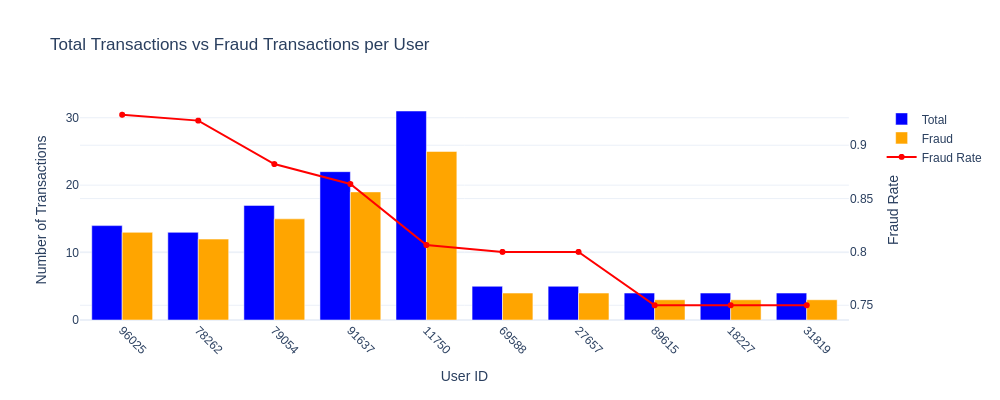

In [21]:
not_100 = not_100.head(10)

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Adding the bar for the total transactions
fig.add_trace(
    go.Bar(
        x=not_100['user_id'],
        y=not_100['total_transactions'],
        name='Total',
        marker_color='blue',
        hovertemplate='Total Transactions: %{y}<extra></extra>',
    ),
    secondary_y=False,
)

# Adding the bar for the fraudulent transactions
fig.add_trace(
    go.Bar(
        x=not_100['user_id'],
        y=not_100['fraud'],
        name='Fraud',
        marker_color='orange',
        hovertemplate='Fraud: %{y}<extra></extra>',
    ),
    secondary_y=False,
)

# Adding the line for the fraud rate
fig.add_trace(
    go.Scatter(
        x=not_100['user_id'],
        y=not_100['fraud_rate'],
        name='Fraud Rate',
        mode='lines+markers',
        line=dict(color='red'),
        hovertemplate='Fraud Rate: %{y}<extra></extra>',
    ),
    secondary_y=True,
)

# Layout configuration
fig.update_layout(
    title="Total Transactions vs Fraud Transactions per User",
    xaxis_title="User ID",
    yaxis_title="Number of Transactions",
    yaxis2_title="Fraud Rate",
    barmode='group',
    legend=dict(
        x=0.98,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.5)',
    ),
    template="plotly_white",
    width=1000,
    height=400,
)

# Axis configuration
fig.update_xaxes(
    tickangle=45,
    type='category',
)
fig.show()

In [22]:
sequential_transactions = data.copy()

# Converter a coluna de data para o tipo datetime
sequential_transactions['transaction_date'] = pd.to_datetime(sequential_transactions['transaction_date'])

# Ordenar o DataFrame por user_id e transaction_date
sequential_transactions = sequential_transactions.sort_values(by=['user_id', 'transaction_date'])

# Calcular a diferença de tempo entre transações consecutivas para cada usuário
sequential_transactions['time_diff'] = sequential_transactions.groupby('user_id')['transaction_date'].diff().abs()

time_threshold = pd.Timedelta(minutes=15)

sequential_transactions['is_sequential'] = sequential_transactions['time_diff'] <= time_threshold

result = sequential_transactions.groupby('user_id').agg(
    total_transactions=('transaction_id', 'size'),
    sequential_transactions=('is_sequential', 'sum'),
    total_amount=('transaction_amount', 'sum'),
    has_cbk_any=('has_cbk', 'any'),
    has_cbk_all=('has_cbk', 'all')
).reset_index()

prop_any = [float(result[result['sequential_transactions'] > i]['has_cbk_any'].value_counts(normalize=True).iloc[0]) for i in range(0, max(result['sequential_transactions']))]

print("Proportion of any fraudulent transaction in a sequence of transactions from the same user:")
for i, p in enumerate(prop_any):
    print(f"{i+2}: {p:.2f}")

print("-"*90)


Proportion of any fraudulent transaction in a sequence of transactions from the same user:
2: 0.51
3: 0.81
4: 1.00
5: 1.00
6: 1.00
7: 1.00
------------------------------------------------------------------------------------------


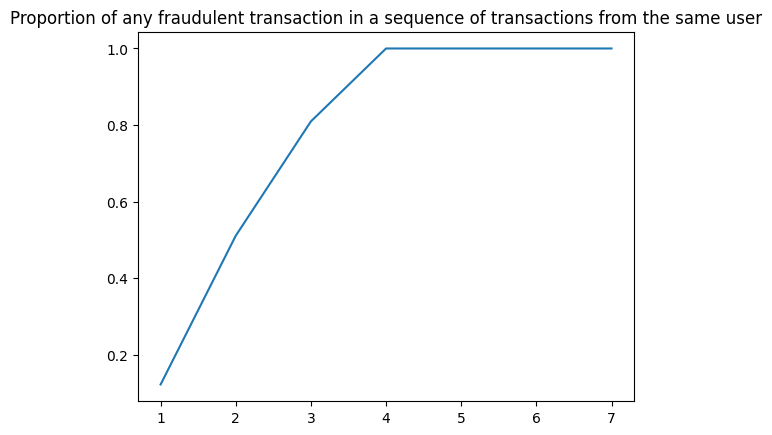

In [23]:
prop_any_dict = {i+2: p for i, p in enumerate(prop_any)}
prop_any_dict[1] = data['has_cbk'].value_counts(normalize=True).iloc[1]
sns.lineplot(prop_any_dict)
plt.title('Proportion of any fraudulent transaction in a sequence of transactions from the same user')

plt.show()

##### Diving deeper: **`merchant_id`**

**Top 3** merchants with the most total transactions

```
Merchant ID: 49205 - Transactions: 73
Merchant ID: 17275 - Transactions: 30
Merchant ID: 4705 - Transactions: 22
```

**Top 3** merchants with the most fraudulent transactions
```
Merchant ID: 17275 - Fraudulent transactions: 22
Merchant ID: 4705 - Fraudulent transactions: 19
Merchant ID: 1308 - Fraudulent transactions: 15
```
**Key Insights:**
* Merchant 49205 stands out with the highest number of transactions (73), but doesn't appear to have the highest fraud rate.
* Merchant 17275, although having the second most transactions (30), has the highest number of fraudulent transactions (22), signaling a potential fraud issue.
* The fraudulent activity is concentrated among a small number of merchants, suggesting that specific merchants may need closer monitoring. 

**Top 3** merchants with the highest fraud rate (that isn't 100%)
```
Merchant ID: 49919.0 - Fraud rate: 0.88 - Total transactions: 8.0
Merchant ID: 66876.0 - Fraud rate: 0.88 - Total transactions: 8.0
Merchant ID: 77130.0 - Fraud rate: 0.87 - Total transactions: 15.0
```
**Key Insights:**
* **66** merchants have 100% of fraudulent transactions
* Merchants 49919 and 66876 have an exceptionally high fraud rate (88%), despite having relatively few transactions (8), which raises red flags for potential fraudulent behavior.
* Merchant 77130, with a fraud rate of 87%, also shows a significant level of suspicious activity with 15 total transactions.
* A high fraud rate coupled with a relatively low number of transactions may suggest targeted fraudulent behavior or vulnerability.

**Possible suspicious patterns:**
* High-value transactions, especially when significantly deviating from the merchant’s average (e.g., exceeding **two standard deviations** from the mean transaction value). 
* Merchants with a high fraud ratio may be failing to prevent fraudulent activities.  

**Recommendations:**
* Increase monitoring for merchants with high fraudulent transaction volumes, such as Merchant 17275 and 4705.
* Investigate merchants with a high fraud ratio and low transaction count, as they may be easy targets for fraudulent schemes.

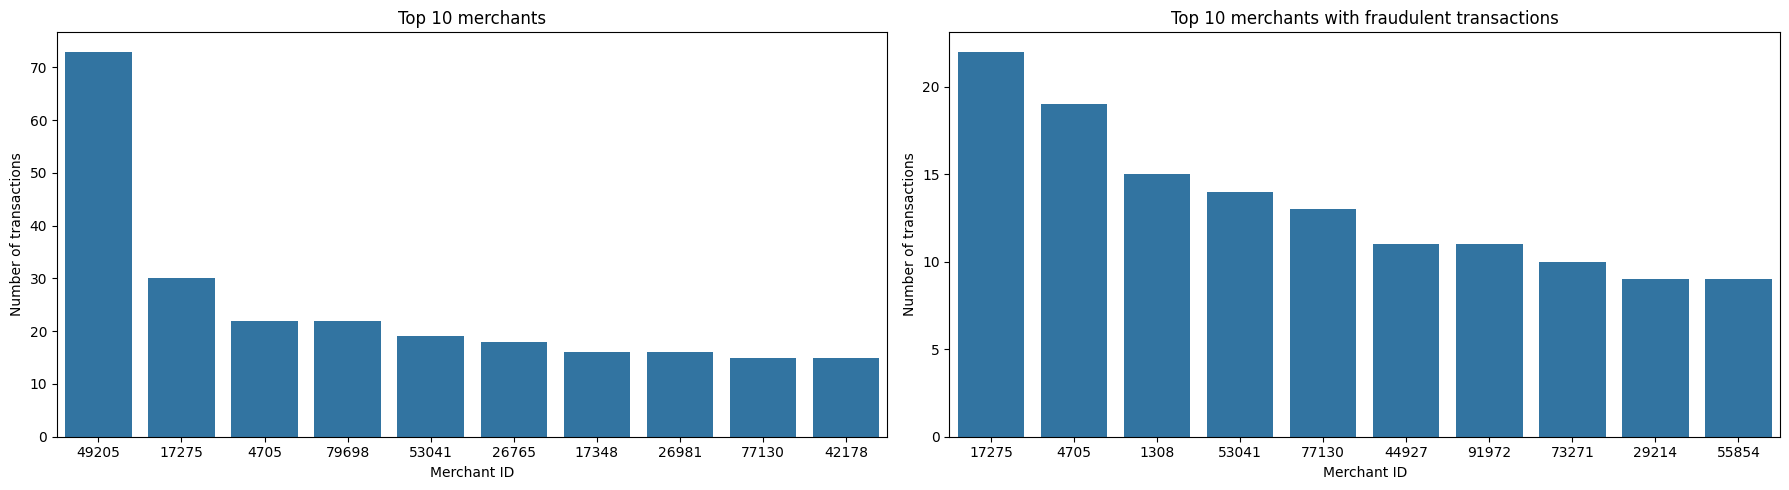

In [24]:
merchants = data['merchant_id'].value_counts().sort_values(ascending=False)
merchants_fraud = fraudulent_transactions['merchant_id'].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.barplot(x=merchants.head(10).index, y=merchants.head(10).values, order=merchants.head(10).index, ax=axes[0])
axes[0].set_title("Top 10 merchants")
axes[0].set_xlabel("Merchant ID")
axes[0].set_ylabel("Number of transactions")

sns.barplot(x=merchants_fraud.head(10).index, y=merchants_fraud.head(10).values, order=merchants_fraud.head(10).index, ax=axes[1])
axes[1].set_title("Top 10 merchants with fraudulent transactions")
axes[1].set_xlabel("Merchant ID")
axes[1].set_ylabel("Number of transactions")

fig.tight_layout()
plt.show()

In [25]:
print("Top 3 merchants with more transactions:")
for i, j in zip(merchants.index[:3], merchants.values[:3]):
    print(f"Merchant ID: {i} - Number of transactions: {j}")

print("-"*50)

print("Top 3 merchants with more fraudulent transactions:")
for i, j in zip(merchants_fraud.index[:3], merchants_fraud.values[:3]):
    print(f"Merchant ID: {i} - Number of fraudulent transactions: {j}")

Top 3 merchants with more transactions:
Merchant ID: 49205 - Number of transactions: 73
Merchant ID: 17275 - Number of transactions: 30
Merchant ID: 4705 - Number of transactions: 22
--------------------------------------------------
Top 3 merchants with more fraudulent transactions:
Merchant ID: 17275 - Number of fraudulent transactions: 22
Merchant ID: 4705 - Number of fraudulent transactions: 19
Merchant ID: 1308 - Number of fraudulent transactions: 15


In [26]:
merchants_transactions = merchants.to_frame().merge(merchants_fraud.to_frame().reset_index(), on='merchant_id', how='left').fillna(0).rename(columns={
    'index': 'merchant_id', 'count_x': 'total_transactions', 'count_y': 'fraud'
    })

merchants_transactions['fraud'] = merchants_transactions['fraud'].astype(int)

merchants_transactions['fraud_rate'] = merchants_transactions['fraud'] / merchants_transactions['total_transactions']

merchants_transactions.sort_values(by='fraud_rate', ascending=False, inplace=True)

print(f"Merchants with only fraudulent transactions: {len(merchants_transactions[merchants_transactions['fraud_rate'] == 1])}")

Merchants with only fraudulent transactions: 66


In [27]:
not_100_merchants = merchants_transactions[merchants_transactions['fraud_rate'] != 1]

for i in range(1, 4):
    print(f"Merchant ID: {not_100_merchants.iloc[i]['merchant_id']} - Fraud rate: {not_100_merchants.iloc[i]['fraud_rate']:.2f} - Total transactions: {not_100_merchants.iloc[i]['total_transactions']}")

Merchant ID: 49919.0 - Fraud rate: 0.88 - Total transactions: 8.0
Merchant ID: 66876.0 - Fraud rate: 0.88 - Total transactions: 8.0
Merchant ID: 77130.0 - Fraud rate: 0.87 - Total transactions: 15.0


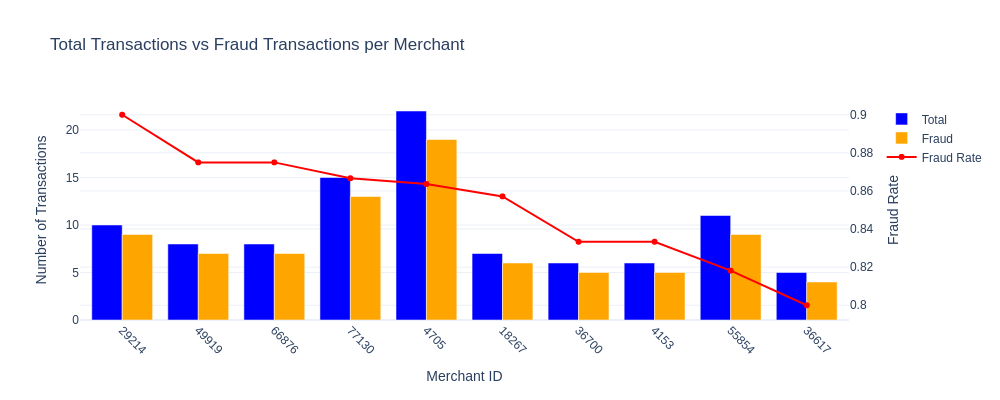

In [28]:
not_100_merchants = not_100_merchants.head(10)

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Adding the bar for the total transactions
fig.add_trace(
    go.Bar(
        x=not_100_merchants['merchant_id'],
        y=not_100_merchants['total_transactions'],
        name='Total',
        marker_color='blue',
        hovertemplate='Total Transactions: %{y}<extra></extra>',
    ),
    secondary_y=False,
)

# Adding the bar for the fraudulent transactions
fig.add_trace(
    go.Bar(
        x=not_100_merchants['merchant_id'],
        y=not_100_merchants['fraud'],
        name='Fraud',
        marker_color='orange',
        hovertemplate='Fraud: %{y}<extra></extra>',
    ),
    secondary_y=False,
)

# Adding the line for the fraud rate
fig.add_trace(
    go.Scatter(
        x=not_100_merchants['merchant_id'],
        y=not_100_merchants['fraud_rate'],
        name='Fraud Rate',
        mode='lines+markers',
        line=dict(color='red'),
        hovertemplate='Fraud Rate: %{y}<extra></extra>',
    ),
    secondary_y=True,
)

# Layout configuration
fig.update_layout(
    title="Total Transactions vs Fraud Transactions per Merchant",
    xaxis_title="Merchant ID",
    yaxis_title="Number of Transactions",
    yaxis2_title="Fraud Rate",
    barmode='group',
    legend=dict(
        x=0.98,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.5)',
    ),
    template="plotly_white",
    width=1000,
    height=400,
)

# Axis configuration
fig.update_xaxes(
    tickangle=45,
    type='category',
)
fig.show()

In [29]:
# Calculating the sum transaction amount for each merchant
merchants_amout = data.groupby('merchant_id')['transaction_amount'].mean()
full_merchants = merchants_transactions.merge(merchants_amout.to_frame().reset_index(), on='merchant_id', how='left')
full_merchants.sort_values(by='fraud', ascending=False, inplace=True)

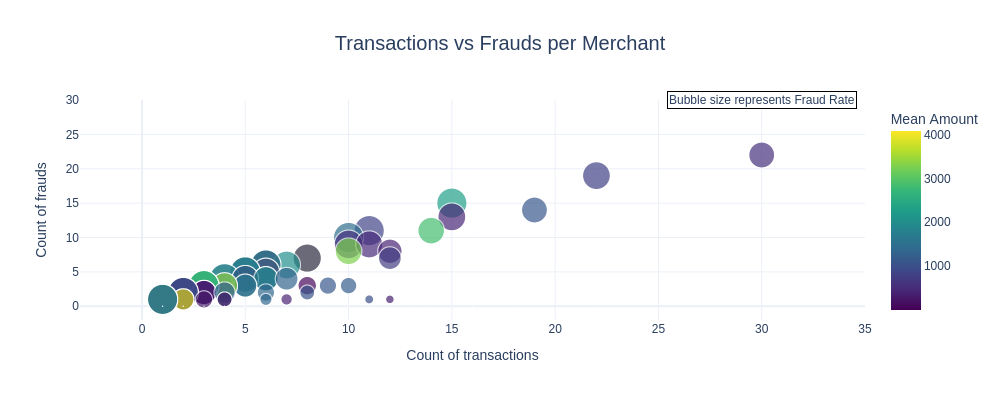

In [30]:
# Creating a scatter plot with the number of transactions, number of frauds, fraud rate and transaction amount for each merchant
fig = px.scatter(
    full_merchants,
    x='total_transactions',
    y='fraud',
    size='fraud_rate',
    color='transaction_amount',
    size_max=30,
    color_continuous_scale='viridis',
    title='Transactions vs Frauds per Merchant',
    labels={
        'total_transactions': 'Count of transactions',
        'fraud': 'Count of frauds',
        'fraud_rate': 'Fraud Rate',
        'transaction_amount': 'Mean Amount'
    }
)

# Adding the merchant ID in the hover
fig.update_layout(
    xaxis_title='Count of transactions',
    yaxis_title='Count of frauds',
    title_font_size=20,
    title_x=0.5,
    hovermode='closest',
    template='plotly_white',
    width=1000,
    height=400,
)

fig.update_xaxes(range=[-3, 35])
fig.update_yaxes(range=[-2, 30])

fig.add_annotation(
    x=30, y=30,  # Posição aproximada da anotação no gráfico
    text="Bubble size represents Fraud Rate",
    showarrow=False,
    font=dict(size=12),
    bgcolor="white",
    bordercolor="black",
    borderwidth=1
)

fig.show()

##### Diving deeper: **`device_id`**

**1. Device general informations**:
```
Total number of devices: 1996
Number of devices without any fraudulent transaction: 1866
Number of devices with at least one fraudulent transaction: 130
```
Only **7%** of the devices have history of fraud.

**2. Unique users != Unique devices**

```
Unique devices: 1996
Unique users: 2704
```

Since the number of devices is greater than the number of users, some users are using more than one device. It's a potencial flag?

**Users with more than one device**
* **24** users have more than one device.
* These users represent **1.22%** of the total user base (**24/1968**).
* The fraud proportion among these users is **54.17%**, which is extremely high.
* Insight: Users with multiple devices are significantly more likely to be involved in fraudulent activities.

**Users with only one device**
* **1944** users have only one device.
* These users represent **98.78%** of the total user base (**1944/1968**).
* The fraud proportion among these users is **5.5%**, which is relatively low.
* Insight: The vast majority of users with a single device exhibit normal behavior, with a low incidence of fraud.

**Possible explanations:**
* **Device sharing:** Users with multiple devices may be sharing accounts or devices with others, increasing the risk of fraudulent activities.
* **Organized fraud:** Users with multiple devices may be involved in organized fraud schemes, where multiple devices are used to carry out fraudulent transactions.
* **Legitimate use:** Although less likely, some users may have legitimate reasons for using multiple devices (e.g., personal and corporate devices).

**Recommendations:**
* Rigorous monitoring: Users with multiple devices should be closely monitored, given the high fraud proportion in this group.
* Additional verification: Implement additional checks (such as two-factor authentication) for users who use more than one device.

**3. Missing values:**
As mentioned earlier, we have some missing values related to **`device_id`**. Let's investigate whether this could indicate suspicious behavior.

Let's perform a hypothesis test:

* Null Hypothesis (H₀): "There is no difference in the proportion of frauds between the two groups"

* Alternative Hypothesis (H₁): "There is a difference in the proportion of frauds between the two groups"

* Group 1 (No device info): 
  - Size: 830
  - Frauds: 67

* Group 2 (Device info):
  - Size: 2369
  - 324

* Results:
  - Z-Statistic: -4.2420
  - P-Value: 0.0000

**Key Insights:**
* The p-value obtained is 0.0000, which is less than the significance level of 0.05. This allows us to reject the null hypothesis.
* We conclude that there is a statistically significant difference in the proportion of fraudulent transactions between the two groups.

In [31]:
# Proportion of devices with at least one fraudulent transaction
devices_with_fraud = len(data[data['has_cbk'] == 1]['device_id'].unique())

print(f"Total number of devices: {data['device_id'].nunique()}")
print(f"Number of devices without any fraudulent transaction: {data['device_id'].nunique() - devices_with_fraud}")
print(f"Number of devices with at least one fraudulent transaction: {devices_with_fraud}")
print(f"Proportion of devices with at least one fraudulent transaction: {devices_with_fraud / data['device_id'].nunique():.2f}")

Total number of devices: 1996
Number of devices without any fraudulent transaction: 1866
Number of devices with at least one fraudulent transaction: 130
Proportion of devices with at least one fraudulent transaction: 0.07


In [32]:
print(f"Unique users: {data['user_id'].nunique()}")

Unique users: 2704


In [33]:
# Grouping the data by user_id and counting the number of unique devices
user_device_count = data.groupby('user_id')['device_id'].nunique().reset_index(name='num_devices')

# Filtering the users with more than one device
users_with_multiple_devices = user_device_count[user_device_count['num_devices'] > 1]
users_with_one_device = user_device_count[user_device_count['num_devices'] == 1]

# Verifying if the user has at least one fraudulent transaction
user_has_cbk = data.groupby('user_id')['has_cbk'].any().reset_index(name='has_any_cbk')

# Merging the data to verify if the user has at least one fraudulent transaction
users_with_multiple_devices = pd.merge(
    users_with_multiple_devices,
    user_has_cbk,
    on='user_id',
    how='left'
)

users_with_one_device = pd.merge(
    users_with_one_device,
    user_has_cbk,
    on='user_id',
    how='left'
)

In [34]:
print(f"Number of users with more than one device: {len(users_with_multiple_devices)}")
print(f"Number of users with only one device: {len(users_with_one_device)}")

Number of users with more than one device: 24
Number of users with only one device: 1944


In [35]:
proportion_multiple_devices = users_with_multiple_devices['has_any_cbk'].value_counts(normalize=True)
proportion_one_device = users_with_one_device['has_any_cbk'].value_counts(normalize=True)
print("Proportion of frauds within users with multiple devices:")
print(proportion_multiple_devices)

print("Proportion of frauds within users with one device:")
print(proportion_one_device)

Proportion of frauds within users with multiple devices:
has_any_cbk
True     0.541667
False    0.458333
Name: proportion, dtype: float64
Proportion of frauds within users with one device:
has_any_cbk
False    0.944444
True     0.055556
Name: proportion, dtype: float64


Text(0.5, 0, 'Has any fraudulent transaction')

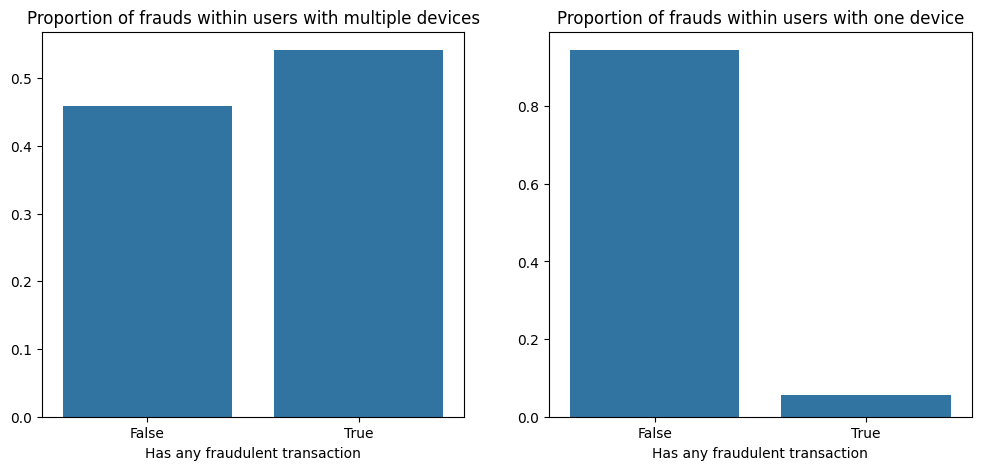

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=proportion_multiple_devices.index, y=proportion_multiple_devices.values, ax=ax[0])
ax[0].set_title("Proportion of frauds within users with multiple devices")
ax[0].set_xlabel("Has any fraudulent transaction")


sns.barplot(x=proportion_one_device.index, y=proportion_one_device.values, ax=ax[1])
ax[1].set_title("Proportion of frauds within users with one device")
ax[1].set_xlabel("Has any fraudulent transaction")

In [37]:
# Grouping the data by device_id and counting the number of unique users
device_user_count = data.groupby('device_id')['user_id'].nunique().reset_index(name='num_users')

# Filtering devices with more than one user
devices_with_multiple_users = device_user_count[device_user_count['num_users'] > 1]

len(devices_with_multiple_users)

0

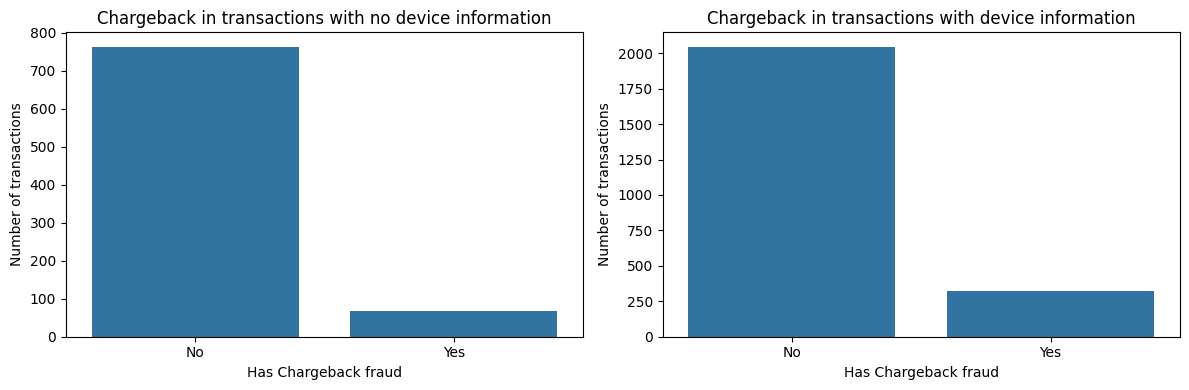

In [38]:

# Checking devices with no information about the device

no_device_info = data[data['device_id'].isna()]
chargeback_counts = no_device_info['has_cbk'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plotting the barplot about the chargeback in transactions with no device information
sns.barplot(
    x=chargeback_counts.index,
    y=chargeback_counts.values,
    ax=ax[0]
)
ax[0].set_title('Chargeback in transactions with no device information')
ax[0].set_ylabel('Number of transactions')
ax[0].set_xlabel('Has Chargeback fraud')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['No', 'Yes'])

# Plotting the barplot about the chargeback in transactions with device information
sns.barplot(
    x=data.dropna()['has_cbk'], y=data.dropna()['has_cbk'].value_counts(), ax=ax[1]
)
ax[1].set_title('Chargeback in transactions with device information')
ax[1].set_ylabel('Number of transactions')
ax[1].set_xlabel('Has Chargeback fraud')
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['No', 'Yes'])


fig.tight_layout()
plt.show()

In [39]:
# Group 1 - Transactions with missing device_id
fraud_missing_device = data[data['device_id'].isna()]['has_cbk']
# Group 2 - Transactions with filled device_id
fraud_filled_device = data[data['device_id'].notna()]['has_cbk']

count = [fraud_missing_device.sum(), fraud_filled_device.sum()]
nobs = [len(fraud_missing_device), len(fraud_filled_device)]

print(f"Number of fraudulent transactions with missing device_id: {count[0]}")
print(f"Number of fraudulent transactions with filled device_id: {count[1]}")

print(f"Number of transactions with missing device_id: {nobs[0]}")
print(f"Number of transactions with filled device_id: {nobs[1]}")


# Hypothesis testing
# H0: There is no difference in the proportion of frauds between the two groups
# H1: There is a difference in the proportion of frauds between the two groups

z_stat, p_value = proportions_ztest(count, nobs)

print(f"Z-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation of the p-value
if p_value < 0.05:
    print("Rejection of the null hypothesis: there is enough evidence to say that there is a significant difference.")
else:
    print("Fail to reject the null hypothesis: there is not enough evidence to say that there is a significant difference.")

Number of fraudulent transactions with missing device_id: 67
Number of fraudulent transactions with filled device_id: 324
Number of transactions with missing device_id: 830
Number of transactions with filled device_id: 2369
Z-Statistic: -4.2420
P-Value: 0.0000
Rejection of the null hypothesis: there is enough evidence to say that there is a significant difference.


##### Diving deeper:  **`card_number`**

**Card general informations**

- Total number of cards: **2925**  
- Number of cards without any fraudulent transaction: **2651**  
- Number of cards with at least one fraudulent transaction: **274**  
- Proportion of cards with at least one fraudulent transaction: **9%**  

**Key Insights**:
- Out of **2,925** cards, **274** have experienced at least one fraudulent transaction.
- **9%** of all cards (274 out of 2,925) have been involved in fraud, so only a few cards are used for frauds.
- The majority (**91%**) of cards have no history of fraudulent transactions, suggesting that most users engage in legitimate activity.

In [40]:
df = data.copy()

# Grouping the data by card_number and counting the number of transactions and frauds
card_analysis = df.groupby('card_number').agg(
    total_transactions=('transaction_id', 'count'),
    total_frauds=('has_cbk', 'sum')
).reset_index()

# Calculating the fraud rate for each card
card_analysis['fraud_rate'] = (card_analysis['total_frauds'] / card_analysis['total_transactions']) * 100
card_analysis = card_analysis.sort_values(by='total_transactions', ascending=False)

In [41]:
number_of_cards = card_analysis['card_number'].nunique()
number_of_cards_without_fraud = card_analysis[card_analysis['fraud_rate'] == 0]['card_number'].nunique()

print(f"Total number of cards: {number_of_cards}")
print(f"Number of cards without any fraudulent transaction: {number_of_cards_without_fraud}")
print(f"Number of cards with at least one fraudulent transaction: {number_of_cards - number_of_cards_without_fraud}")
print(f"Proportion of cards with at least one fraudulent transaction: {(number_of_cards - number_of_cards_without_fraud) / number_of_cards:.2f}")

Total number of cards: 2925
Number of cards without any fraudulent transaction: 2651
Number of cards with at least one fraudulent transaction: 274
Proportion of cards with at least one fraudulent transaction: 0.09


##### Diving deeper:  **`transaction_date`**

**Full period of analysis**:
* All of our transactions occurred in November 2019.
* The period with the highest number of transactions is between **2019-11-21** and **2019-11-24**:
  - A closer look in this period:
    ```
    Number of transactions: 869
    Non-fraudulent transactions: 773
    Fraudulent transactions: 96
    ```

* **Analysis by weekday**:
  - Looking at the distribution of transactions by weekday, we noticed that the busiest days are Thursday to Sunday.
  - A peak in the fraud rate was observed on Wednesday.
  - As the number of transactions increases, the number of fraudulent transactions also increases.

* **Analysis by hour of the day**:
  - In terms of transaction distribution by hour, the peak period for transactions is between 4 p.m. and 9 p.m.
  - Similar to the weekday analysis, when the number of transactions increases, fraudulent transactions also rise.
  - The fraud rate tends to spike between 6 p.m. and 3 a.m.

* **Possible explanations**:
  - **Peak Transaction Days (Thursday and Friday):** Increased fraud during these days could be due to a higher volume of transactions over the weekend.
  - **Increased Fraud Between 6 p.m. and 3 a.m.:** Fraudsters may prefer to operate during these hours due to reduced monitoring and oversight, or because transaction volumes are generally higher during this time.

* **Recommendations**:
  - **Enhance monitoring during peak times:** Implement more authentication checks between Thursday and Sunday, and between 6 p.m. and 3 a.m., when fraud rates are higher.
  - **Adjust fraud detection mechanisms to peak times:** Adjust fraud detection mechanisms to become more sensitive during periods of high transaction volume, ensuring that anomalies are detected promptly.

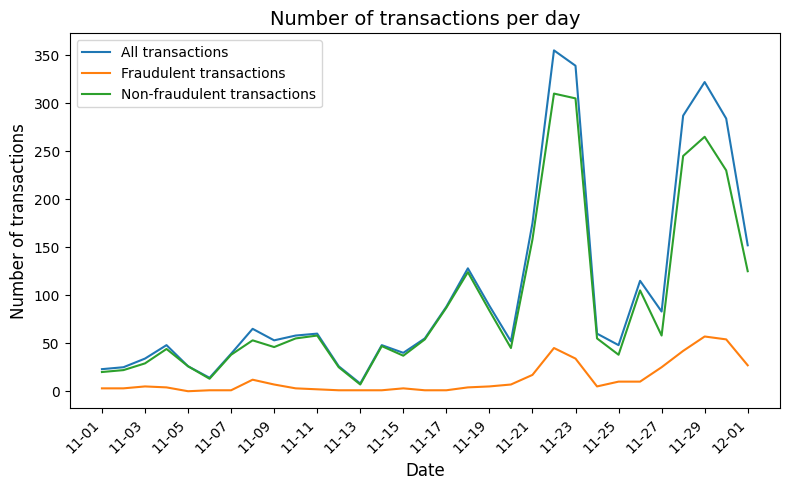

In [42]:
# Number of transactions per day
transaction_per_day = data.set_index('transaction_date').resample('D').count()['transaction_id']
fraudulent_transactions_per_day = fraudulent_transactions.set_index('transaction_date').resample('D').count()['transaction_id']
non_fraudulent_transactions_per_day = non_fraudulent_transactions.set_index('transaction_date').resample('D').count()['transaction_id']

# Plotting the number of transactions per day
plt.figure(figsize=(8, 5))

sns.lineplot(x=transaction_per_day.index, y=transaction_per_day.values, label='All transactions')
sns.lineplot(x=fraudulent_transactions_per_day.index, y=fraudulent_transactions_per_day.values, label='Fraudulent transactions')
sns.lineplot(x=non_fraudulent_transactions_per_day.index, y=non_fraudulent_transactions_per_day.values, label='Non-fraudulent transactions')

plt.title("Number of transactions per day", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of transactions", fontsize=12)
plt.xticks(rotation=45, ha='right')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

In [43]:
time_absolute = data.copy()
time_absolute['transaction_date'] = pd.to_datetime(time_absolute['transaction_date'])

# Extracting the day of the week and the hour of the day
time_absolute['weekday'] = time_absolute['transaction_date'].dt.weekday
time_absolute['hour'] = time_absolute['transaction_date'].dt.hour

# 1. Weekday analysis
transactions_by_weekday = time_absolute.groupby(['weekday', 'has_cbk']).size().unstack(fill_value=0)
transactions_by_weekday.columns = ['non_fraud', 'fraud']
transactions_by_weekday['all_transactions'] = transactions_by_weekday['fraud'] + transactions_by_weekday['non_fraud']

# Mapping the weekday numbers to the names
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
transactions_by_weekday.index = transactions_by_weekday.index.map(weekday_map)

# 2. Hour analysis
transactions_by_hour = time_absolute.groupby(['hour', 'has_cbk']).size().unstack(fill_value=0)
transactions_by_hour.columns = ['non_fraud', 'fraud']
transactions_by_hour['all_transactions'] = transactions_by_hour['fraud'] + transactions_by_hour['non_fraud']

# Fixing the missing row at 7:00
missing_row = pd.DataFrame({'non_fraud': [0], 'fraud': [0], 'all_transactions': [0]}, index=[7])
transactions_by_hour = pd.concat([transactions_by_hour.loc[:6], missing_row, transactions_by_hour.loc[7:]])

In [44]:
# Calculating the fraud rate
time_rate = data.copy()

time_rate['hour'] = time_rate['transaction_date'].dt.hour
time_rate['weekday'] = time_rate['transaction_date'].dt.weekday

weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
time_rate['weekday_name'] = time_rate['weekday'].map(weekday_map)

# Calculating the fraud rate by weekday
fraud_by_weekday = time_rate.groupby('weekday')['has_cbk'].mean().reset_index()
fraud_by_weekday.rename(columns={'has_cbk': 'fraud_rate'}, inplace=True)
fraud_by_weekday['weekday_name'] = fraud_by_weekday['weekday'].map(weekday_map)

# Calculating the fraud rate by hour
fraud_by_hour = time_rate.groupby('hour')['has_cbk'].mean().reset_index()
fraud_by_hour.rename(columns={'has_cbk': 'fraud_rate'}, inplace=True)
missing_row = pd.DataFrame({'hour': [7], 'fraud_rate': [0]})
fraud_by_hour = pd.concat([fraud_by_hour.loc[:6], missing_row, fraud_by_hour.loc[7:]])

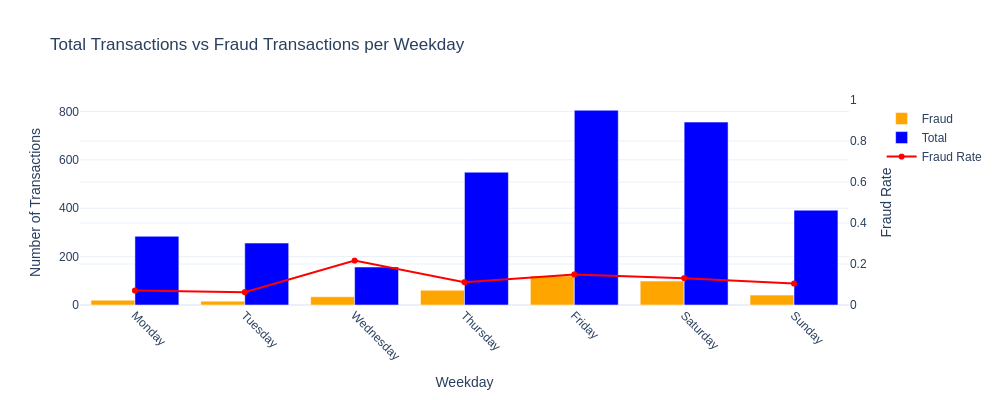

In [45]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Adding bars for fraudulent transactions
fig.add_trace(
    go.Bar(
        x=transactions_by_weekday.index,
        y=transactions_by_weekday['fraud'],
        name='Fraud',
        marker_color='orange',
        hovertemplate='Fraud: %{y}<extra></extra>',
    ),
    secondary_y=False,
)

# Adding bars for all transactions
fig.add_trace(
    go.Bar(
        x=transactions_by_weekday.index,
        y=transactions_by_weekday['all_transactions'],
        name='Total',
        marker_color='blue',
        hovertemplate='Non-Fraud: %{y}<extra></extra>',
    ),
    secondary_y=False,
)

# Adding the line for the fraud rate
fig.add_trace(
    go.Scatter(
        x=fraud_by_weekday['weekday_name'],
        y=fraud_by_weekday['fraud_rate'],
        name='Fraud Rate',
        mode='lines+markers',
        line=dict(color='red'),
        hovertemplate='Fraud Rate: %{y:.2f}<extra></extra>',
    ),
    secondary_y=True,
)

# Layout configuration
fig.update_layout(
    title="Total Transactions vs Fraud Transactions per Weekday",
    xaxis_title="Weekday",
    yaxis_title="Number of Transactions",
    yaxis2_title="Fraud Rate",
    barmode='group',
    legend=dict(
        x=0.98,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.5)',
    ),
    template="plotly_white",
    width=1000,
    height=400,
)

# Axis configuration
fig.update_xaxes(
    tickangle=45,
    type='category',
)

# Axis configuration
fig.update_yaxes(title_text="Number of Transactions", secondary_y=False)
fig.update_yaxes(title_text="Fraud Rate", secondary_y=True, range=[0, 1])

fig.show()

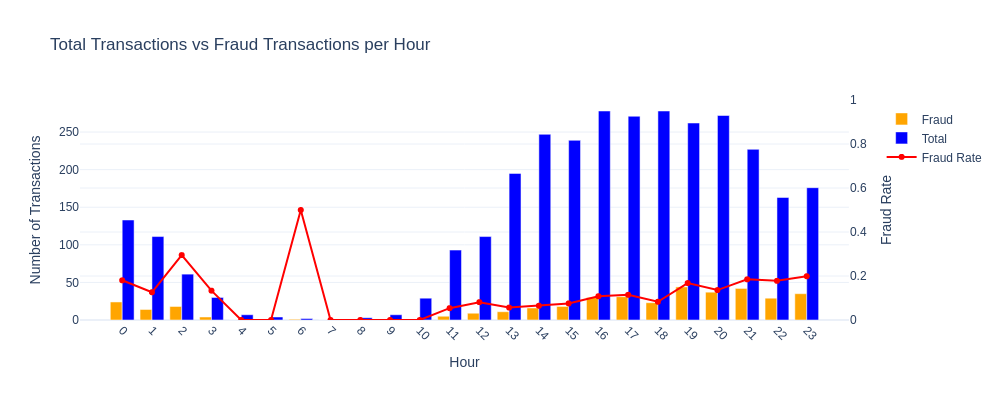

In [46]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Adding bars for fraudulent transactions
fig.add_trace(
    go.Bar(
        x=transactions_by_hour.index,
        y=transactions_by_hour['fraud'],
        name='Fraud',
        marker_color='orange',
        hovertemplate='Fraud: %{y}<extra></extra>',
    ),
    secondary_y=False,
)

# Adding bars for all transactions
fig.add_trace(
    go.Bar(
        x=transactions_by_hour.index,
        y=transactions_by_hour['all_transactions'],
        name='Total',
        marker_color='blue',
        hovertemplate='Non-Fraud: %{y}<extra></extra>',
    ),
    secondary_y=False,
)

# Adding the line for the fraud rate
fig.add_trace(
    go.Scatter(
        x=fraud_by_hour['hour'],
        y=fraud_by_hour['fraud_rate'],
        name='Fraud Rate',
        mode='lines+markers',
        line=dict(color='red'),
        hovertemplate='Fraud Rate: %{y:.2f}<extra></extra>',
    ),
    secondary_y=True,
)

# Layout configuration
fig.update_layout(
    title="Total Transactions vs Fraud Transactions per Hour",
    xaxis_title="Hour",
    yaxis_title="Number of Transactions",
    yaxis2_title="Fraud Rate",
    barmode='group',
    legend=dict(
        x=0.98,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.5)',
    ),
    template="plotly_white",
    width=1000,
    height=400,
)

# Axis configuration
fig.update_xaxes(
    tickangle=45,
    type='category',
)

# Axis configuration
fig.update_yaxes(title_text="Number of Transactions", secondary_y=False)
fig.update_yaxes(title_text="Fraud Rate", secondary_y=True, range=[0, 1])

fig.show()

#### Summary

**`transaction_amount`** Is the most valuable feature in our data, having the biggest correlation to the fraudulent transactions
* Set a threshold to the value:
  - **Conservative Threshold** (2 standard deviations above the third quartile): 
  **981.68 + 2 × 889.10 = 2759.88**  \
  Any transaction above **$2759.88** would be considered high risk.   

  - **Moderate Threshold** (1 standard deviation above the third quartile):
  **981.68 + 1 × 889.10 = 1870.78** \
  Transactions above **$1870.78** would be considered at moderate risk.  

  - **Aggressive Threshold** (Transactins above the third quartile)\
  Transactions above **981.68** would be considered at risk. 

  - **Even more agressive Threshold** (Transactions above the intersection of KDE curves for Fraudulent and Non-Fraudulent transactions)\
  Transactions above **640.55** would be considered at risk. 

>Additionally, a more aggressive threshold can be derived from the intersection of KDE curves for fraudulent and non-fraudulent transactions. This threshold, at $640.55, represents the point where the likelihood of fraud starts to increase, based on empirical distribution rather than standard deviation calculations.

* **User-Oriented Threshold (Dynamic Risk Assessment per User)**  
  - **High-Risk Threshold (3 standard deviations above the user's mean):**  
    Transactions above **\(mean_user + 3 std_user \)** are considered highly anomalous and potentially fraudulent.  

  - **Moderate-Risk Threshold (2 standard deviations above the user's mean):**  
    Transactions exceeding **\(mean_user + 2 std_user \)** indicate moderate to high risk.  

  - **Low-Risk Threshold (1 standard deviation above the user's mean):**  
    Transactions above **\(mean_user + 1 std_user \)** may be unusual but not necessarily fraudulent.  

>This approach ensures that risk detection adapts to individual spending habits, reducing false positives for high-spending users while improving fraud detection for lower-spending users.

**`user_id`** is also an interesting feature to analyze. We observe a high rate of recurring fraudsters, so it is important to focus on several key points:
* High rate of recurring fraudsters,
* Users with a history of fraudulent transactions should be treated with caution.
* Users with a high number of transactions and a high fraud rate should be classified as high-risk users.
* Users with multiple devices should be closely monitored.
* Be awared of a sequence of transactions.
* Consider using a user-oriented threshold based on the concepts explained above in a rule-based fraud prevention system.

**`merchant_id`**:

* Merchants with a high number of fraudulent transactions should be investigated to determine whether they are involved in a fraud scheme or if their security measures are inadequate.
* Set a merchant-oriented threshold using the concepts outlined in the User-Oriented Threshold.

**`device_id`**: 

* We observed that only 7%  of the devices are responsible for all frauds, this suggests a strong correlation between specific devices and fraudulent activity.
* Users who utilize a high number of devices are more likely to have at least one fraudulent transaction, this pattern may indicate that users with multiple devices are more prone to fraud.
* Devices with a history of fraudulent transactions should be treated with caution.

**`card_number`**: 

* We observed that only 9%  of the cards are responsible for all frauds, this suggests a strong correlation between specific cards and fraudulent activity.
* Cards with a history of fraudulent transactions should be treated with caution.

**`transaction_date`** 

* Weekday analysis:
  - The majority of transactions (both legitimate and fraudulent) occur between Thursday and Sunday.

* Hourly analysis:
  - Most transactions (both legitimate and fraudulent) take place between 4 p.m. and 8 p.m.
  - The highest fraud rates are observed between 9 p.m. and 2 a.m., with the exception of 6 a.m., where only two transactions were recorded (one fraudulent and one legitimate).

* Set a potential time limit for high-value transactions to enhance fraud detection.

## Anti-Fraud Solution

### Machine-Learning Approach


In this session, I will describe the steps I took to implement a machine learning-based solution for fraud detection.

#### Steps Overview
##### 1. Loading the Data and Splitting into Features and Target
The first step is to load the data and separate it into features and the target variable.

##### 2. Creating the `FeatureEngineering` Class
The `FeatureEngineering` class is responsible for creating new features that will be used to train the model. Some of the key features include:

- **Time Features**: Weekday and Hour features will undergo cyclical encoding using the Sinusoidal-Cosinusoidal transformation formula.

- **Device Missing**: A boolean feature indicating whether the device information is missing.

- **User Avg Amount**: The average amount spent by the user.

- **Merchant Avg Amount**: The average amount spent at the merchant.

##### 3. Splitting Data into Training and Testing Sets
Once the features are prepared, the next step is to split the data into training and testing sets.

##### 4. Applying Preprocessing on the Data

- **Numerical Features**:  Apply an imputer with median values and then scale using Standard Scaler.

- **Categorical Features**: Impute missing values with -1 (for missing Device ID information).

##### 5. Feature Creation and Transformation
We will use the `FunctionTransformer` and the `FeatureEngineering` class to create new features and preprocess them in sequence.

##### 6. Selecting the Most Important Metric to Monitor
Some possibilities include:

- **F1 Score**: If a balance between detecting fraud and minimizing false positives is needed.

- **Class 1 Recall**: If the main objective is to detect as many frauds as possible, even if it leads to more false positives.

- **ROC AUC**:  If the goal is to evaluate the model's ability to distinguish between fraudulent and legitimate transactions, especially in the case of class imbalance.

##### 7. Chosen Approach
- I chose to prioritize 'F1 Score' during the randomized search to maximize the model's ability to identify frauds without a lot of false alarms, even at the cost of more false alarms. I will also monitor ROC AUC to evaluate the model's overall ability to distinguish between fraudulent and legitimate transactions and ensure its generalization capability.

##### 8. Model Selection
Several models can be considered:

- **Logistic Regression**: Simple and fast, but may struggle with generalization. Will be used as a baseline.

- **XGBoost**:Superior performance, handles imbalanced classes well but may overfit with small datasets. Will be used as the definitive model.

This approach combines feature engineering, preprocessing, and model selection strategies to create an effective fraud detection solution using machine learning.

#### Data Preparation

In [47]:
df = pd.read_csv('transactional-sample.csv')

df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# balancing the dataset
X = df.drop(columns=['has_cbk', 'card_number', 'transaction_id'])
y = df['has_cbk'].astype(int)

# Under Sampler will be directed aplicated in the XGBoost model using the
data_fraud = df[df['has_cbk'] == 1]
data_non_fraud = df[df['has_cbk'] == 0]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
class FeatureEngineering:
    """Performs feature engineering on a given transaction dataset.

    This class provides methods to generate new features from transactional data,
    including time-based features, cyclic encoding, missing value indicators,
    and transaction amount averages. It enables structured feature transformation
    to improve model performance.

    Attributes:
        df (pd.DataFrame): The DataFrame containing transaction data.

    Methods:
        create_time_features(): Generates time-based features such as weekday and hour.
        cyclic_encoding(column, period): Applies cyclic encoding using sine and cosine transformations.
        create_device_missing(): Creates a binary feature indicating missing device information.
        create_avg_amount_user(): Computes the average transaction amount per user.
        create_avg_amount_merchant(): Computes the average transaction amount per merchant.
        apply_all_transformations(): Applies all transformations in the correct sequence.
    """
    def __init__(self, df: pd.DataFrame):
        """Initializes the FeatureEngineering class with a DataFrame.

        This constructor assigns the provided DataFrame to an instance variable,
        allowing feature transformations to be applied.

        Args:
            df (pd.DataFrame): The dataset containing transaction records.
        """
        self.df = df

    def create_time_features(self) -> pd.DataFrame:
        """Generates time-based features such as weekday and hour.

        This method extracts temporal features from the 'transaction_date' column,
        including the weekday and hour of the transaction. The original
        'transaction_date' column is removed after feature extraction.

        Returns:
            pd.DataFrame: The modified DataFrame with the new time-based features.

        """
        self.df['weekday'] = self.df['transaction_date'].dt.weekday
        self.df['hour'] = self.df['transaction_date'].dt.hour
        self.df.drop(columns=['transaction_date'], inplace=True)
        return self.df

    def cyclic_encoding(self, column: str, period: int) -> pd.DataFrame:
        """Encodes a column cyclically using sine and cosine transformations.

        This method applies a cyclic encoding to a specified column by
        transforming its values into sine and cosine components. The original
        column is removed after encoding.

        Args:
            column (str): The name of the column to be cyclically encoded.
            period (int): The period of the cycle (e.g., 12 for months, 24 for hours).

        Returns:
            pd.DataFrame: The modified DataFrame with the new sine and cosine columns.

        """
        self.df[column + '_sin'] = np.sin(2 * np.pi * self.df[column] / period)
        self.df[column + '_cos'] = np.cos(2 * np.pi * self.df[column] / period)
        self.df.drop(columns=[column], inplace=True)
        return self.df

    def create_device_missing(self) -> pd.DataFrame:
        """Creates a feature indicating whether the device is missing.

        This method generates a new binary feature, 'device_missing', which
        indicates whether the 'device_id' column has a missing value (NaN).
        The feature is represented as an integer (0 or 1).

        Returns:
            pd.DataFrame: The modified DataFrame with the new 'device_missing' feature.

        """
        self.df['device_missing'] = self.df['device_id'].isna()
        self.df['device_missing'] = self.df['device_missing'].astype(int)
        return self.df

    def create_avg_amount_user(self) -> pd.DataFrame:
        """Creates a feature with the average transaction amount per user.

        This method calculates the average transaction amount for each user
        based on the 'user_id' column and assigns it to a new feature, 'avg_amount'.

        Returns:
            pd.DataFrame: The modified DataFrame with the new 'avg_amount' feature.
        """
        self.df['avg_amount'] = self.df.groupby('user_id')['transaction_amount'].transform('mean')
        return self.df

    def create_avg_amount_merchant(self) -> pd.DataFrame:
        """Creates a feature with the average transaction amount per merchant.

        This method calculates the average transaction amount for each merchant
        based on the 'merchant_id' column and assigns it to a new feature,
        'avg_amount_merchant'.

        Returns:
            pd.DataFrame: The modified DataFrame with the new 'avg_amount_merchant' feature.
        """
        self.df['avg_amount_merchant'] = self.df.groupby('merchant_id')['transaction_amount'].transform('mean')
        return self.df

    def apply_all_transformations(self) -> pd.DataFrame:
        """Applies all feature engineering transformations in the correct order.

        This method sequentially applies all necessary transformations to the
        dataset, including time-based feature extraction, cyclic encoding,
        missing device detection, and transaction amount averaging.

        Transformations applied:
        - Extracts 'weekday' and 'hour' from 'transaction_date'.
        - Applies cyclic encoding to 'weekday' (7-day cycle) and 'hour' (24-hour cycle).
        - Creates a binary feature indicating missing device information.
        - Computes the average transaction amount per user.
        - Computes the average transaction amount per merchant.

        Returns:
            pd.DataFrame: The fully transformed DataFrame.
        """
        # Cria features de tempo
        self.create_time_features()

        # Codifica features cíclicas (exemplo para 'weekday' e 'hour')
        self.cyclic_encoding('weekday', 7)  # 7 dias na semana
        self.cyclic_encoding('hour', 24)    # 24 horas no dia

        # Cria feature de dispositivo ausente
        self.create_device_missing()

        # Cria médias de valor de transação por usuário e comerciante
        self.create_avg_amount_user()
        self.create_avg_amount_merchant()

        return self.df

In [49]:
# Creating data pipelines

# Defining the features to be used in the pipeline
numeric_features = ['transaction_amount', 'avg_amount', 'avg_amount_merchant']

categorical_features = ['device_id', 'merchant_id', 'user_id', 'device_missing']

cyclic_features = ['weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']

# Creating a transformer for feature engineering
feature_engineering_transformer = FunctionTransformer(
    lambda df: FeatureEngineering(df.copy()).apply_all_transformations(), validate=False
)

# Preprocessing pipelines for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1.)),
])

# Combining the preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough')

# Creating a pipeline with the feature engineering and preprocessing steps
pipeline = Pipeline(steps=[
    ('engineering', feature_engineering_transformer),
    ('preprocessing', preprocessor)
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [50]:
# Checking if the data was transformed correctly
pd.DataFrame(X_train_transformed, columns = numeric_features + categorical_features + cyclic_features).head(5)

,transaction_amount,avg_amount,avg_amount_merchant,device_id,merchant_id,user_id,device_missing,weekday_sin,weekday_cos,hour_sin,hour_cos
0,-0.837163,-0.867044,-0.923435,165537.0,47863.0,20178.0,0.0,-0.433884,-0.900969,1.224647e-16,-1.000000
1,-0.574649,-0.595160,0.618249,-1.0,34433.0,21994.0,1.0,0.974928,-0.222521,-5.000000e-01,-0.866025
2,0.400141,0.414424,0.441377,918683.0,72414.0,67927.0,0.0,0.433884,-0.900969,-9.659258e-01,-0.258819
3,-0.263226,-0.229400,-0.256894,342890.0,17275.0,11750.0,0.0,-0.433884,-0.900969,-9.659258e-01,0.258819
4,2.926080,2.080462,2.215772,-1.0,77570.0,75889.0,1.0,0.974928,-0.222521,1.224647e-16,-1.000000


#### Logistic Regression (baseline)

1. Precision, Recall, and F1-Score

  * Class 0 (Negative):
    - **Precision (0.93):** High precision when predicting class 0, with a 93% chance of being correct.
    - **Recall (0.76):** The model identifies 76% of the actual class 0 samples.
    - **F1-Score (0.84):** Good balance between precision and recall.

  * Class 1 (Positive):
    - **Precision (0.30):** Low precision with many false positives.
    - **Recall (0.63):** Identifies 63% of the actual class 1 samples.
    - **F1-Score (0.41):** Poor performance due to low precision.

3. **ROC AUC (0.7680):** The value of 0.7680 indicates a reasonable ability to distinguish between classes, with room for improvement.

4. Identified Issues
  * Poor performance for class 1 due to low precision and F1-Score.
  * The model tends to predict class 0 due to the class imbalance, even using **`class_weight='balanced'`**.

5. Learning Curves
  * The behavior observed in the learning curves suggests underfitting, as both curves are converging at the lower end of the graph.
  * A possible explanation is that the logistic regression model is unable to capture the complexity of the problem effectively.

6. Confusion matrix \
The confusion matrix reinforces the point made in the previous text about underfitting and model performance issues.
  * True Positives: 420
  * False Positives: 130
  * True Negatives: 33
  * False Negatives: 57

In [51]:
baseline = LogisticRegression(max_iter=1000)

base_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced', None]
}

# Defining scorer for f1 classs 1
f1_scorer_classe_1 = make_scorer(f1_score, average='binary', pos_label=1)

base_search = RandomizedSearchCV(
    baseline,
    base_params,
    n_iter=20,
    scoring=f1_scorer_classe_1,
    n_jobs=-1,
    cv=5,
    random_state=42
)

# Fit the grid
base_search.fit(X_train_transformed, y_train)

# Get the best model
best_base = base_search.best_estimator_
print("Best parameters found: ", base_search.best_params_)

Best parameters found:  {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.01}


In [52]:
# Training model
base_search.fit(X_train_transformed, y_train)
y_pred_base = base_search.predict(X_test_transformed)

# Evaluating the model
print(classification_report(y_test, y_pred_base))

print("-"*50)

# ROC AUC
y_pred_base_proba = base_search.predict_proba(X_test_transformed)[:, 1]
roc_auc_base = roc_auc_score(y_test, y_pred_base_proba)
print(f"ROC AUC: {roc_auc_base:.4f}")

              precision    recall  f1-score   support

           0       0.93      0.76      0.84       550
           1       0.30      0.63      0.41        90

    accuracy                           0.75       640
   macro avg       0.62      0.70      0.62       640
weighted avg       0.84      0.75      0.78       640

--------------------------------------------------
ROC AUC: 0.7680


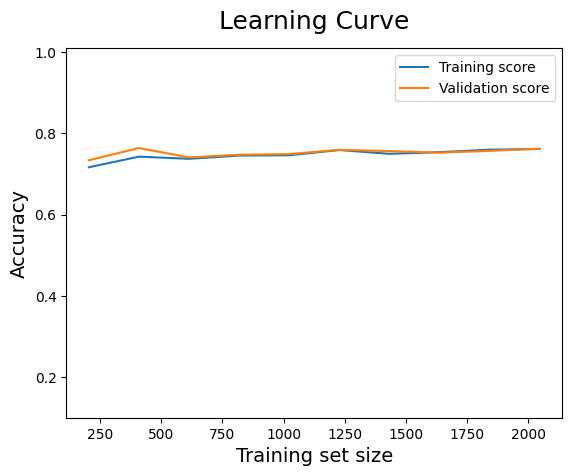

In [53]:
# Defining training sizes
train_sizes = np.linspace(0.1, 1.0, 10)  # 10% to 100% in 10 steps

#  Scores, train sizes and absolute train sizes
train_sizes_abs, train_scores, test_scores = learning_curve(
    estimator=best_base,
    X=X_train_transformed,
    y=y_train,
    train_sizes=train_sizes,
    cv=5,
    scoring='accuracy'
)

# Mean scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot
plt.plot(train_sizes_abs, train_scores_mean, label='Training score')
plt.plot(train_sizes_abs, test_scores_mean, label='Validation score')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning Curve', fontsize=18, y=1.03)
plt.ylim([.1, 1.01])

plt.legend()
plt.show()

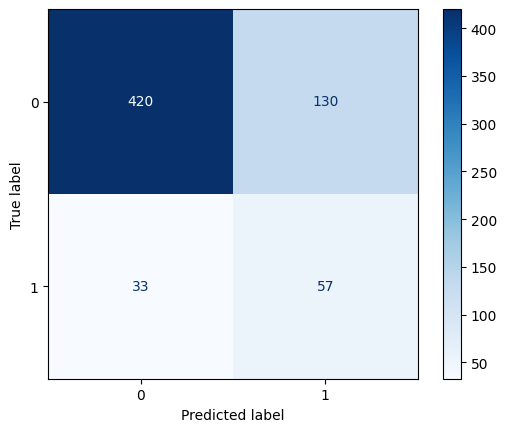

In [54]:
# Confusion matrix
cm_base = confusion_matrix(y_test, y_pred_base)

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_base, display_labels=best_base.classes_)
disp.plot(cmap='Blues')
plt.show()


#### XGBoost 

**No balancing data**
1. Precision, Recall, and F1-Score

  * Class 0 (Negative):
    - **Precision (0.94):** High precision when predicting class 0, with a 94% chance of being correct.
    - **Recall (0.96):** The model identifies 96% of the actual class 0 samples.
    - **F1-Score (0.95):** High balance between precision and recall.

  * Class 1 (Positive):
    - **Precision (0.71):** Good precision with some false positives.
    - **Recall (0.62):** The model identifies 62% of the actual class 1 samples.
    - **F1-Score (0.66):** Reasonable performance between precision and recall.

3. **ROC AUC (0.9038):** Indicates a good ability to distinguish between classes.

4. Identified Issues
  * Using **`scale_pos_weight=[len(data_non_fraud) / len(data_fraud)]`** to deal with class imbalancing.

5. Learning Curves
  * The learning curves are good, as both curves are converging at the upper end of the graph.

6. Confusion matrix  
  * True Positives: 538 -> `No fraud`predicted as `No fraud`
  * False Positives: 12 -> `No fraud` predicted as `Fraud`
  * True Negatives: 30 -> `Fraud` predicted as `NoFraud`
  * False Negatives: 60 -> `No fraud` predicted as `Fraud`


**Balancing data** 

1. Precision, Recall, and F1-Score

  * Class 0 (Negative):
    - **Precision (0.91):** High precision when predicting class 0, with a 91% chance of being correct.
    - **Recall (0.98):** The model identifies 98% of the actual class 0 samples.
    - **F1-Score (0.94):** High balance between precision and recall.

  * Class 1 (Positive):
    - **Precision (0.72):** Good precision with some false positives.
    - **Recall (0.38):** The model identifies only 38% of the actual class 1 samples.
    - **F1-Score (0.50):** Poor performance due to low recall.

3. **ROC AUC (0.8692):** Indicates a reasonable ability to distinguish between classes.

4. Identified Issues
  * Using UnderSampling to deal with class imbalancing.

5. Learning Curves
  * The learning curves are indicating a possible overfitting.

6. Confusion matrix  
  * True Positives: 538 -> `No fraud`predicted as `No fraud`
  * False Positives: 12 -> `No fraud` predicted as `Fraud`
  * True Negatives: 60 -> `Fraud` predicted as `NoFraud`
  * False Negatives: 30 -> `No fraud` predicted as `Fraud`


##### No balancing

In [55]:
# Creating data pipelines

# Defining the features to be used in the pipeline
numeric_features = ['transaction_amount', 'avg_amount', 'avg_amount_merchant']

categorical_features = ['device_id', 'merchant_id', 'user_id', 'device_missing']

cyclic_features = ['weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']

# Creating a transformer for feature engineering
feature_engineering_transformer = FunctionTransformer(
    lambda df: FeatureEngineering(df.copy()).apply_all_transformations(), validate=False
)

# Preprocessing pipelines for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1.)),
])

# Combining the preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough')

# Creating a pipeline with the feature engineering and preprocessing steps
pipeline = Pipeline(steps=[
    ('engineering', feature_engineering_transformer),
    ('preprocessing', preprocessor)
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [56]:
# Defining param grid
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 1, 5],
    'scale_pos_weight': [len(data_non_fraud) / len(data_fraud)]
}

# Instantiate the model
model_xgb = XGBClassifier(random_state=42)

# Start the grid
search = RandomizedSearchCV(
    model_xgb,
    param_distributions=params,
    scoring=f1_scorer_classe_1,
    n_jobs=-1,
    cv=5,
    verbose=1,
    n_iter=500
)

# Fit the grid
search.fit(X_train_transformed, y_train)

# Get the best model
best_model = search.best_estimator_
print("Best parameters found: ", search.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best parameters found:  {'subsample': 1, 'scale_pos_weight': 7.181585677749361, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5}


In [57]:
# Training model
best_model.fit(X_train_transformed, y_train)
y_pred = best_model.predict(X_test_transformed)

# Evaluating the model
print(classification_report(y_test, y_pred))

print("-"*50)

# ROC AUC
y_pred_proba = best_model.predict_proba(X_test_transformed)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       550
           1       0.79      0.62      0.70        90

    accuracy                           0.92       640
   macro avg       0.86      0.80      0.83       640
weighted avg       0.92      0.92      0.92       640

--------------------------------------------------
ROC AUC: 0.9086


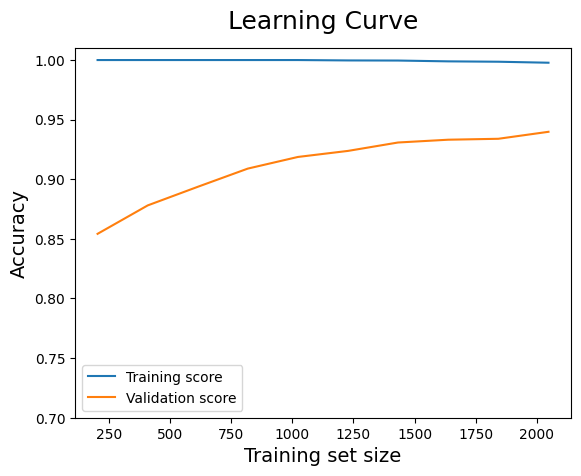

In [58]:
def plot_learning_curve(X, y, estimator, ylim):
    # Defining training sizes
    train_sizes = np.linspace(0.1, 1.0, 10)  # 10% to 100% in 10 steps

    #  Scores, train sizes and absolute train sizes
    train_sizes_abs, train_scores, test_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=5,
        scoring='accuracy'
    )

    # Mean scores
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Plot
    plt.plot(train_sizes_abs, train_scores_mean, label='Training score')
    plt.plot(train_sizes_abs, test_scores_mean, label='Validation score')
    plt.ylabel('Accuracy', fontsize=14)
    plt.xlabel('Training set size', fontsize=14)
    plt.title('Learning Curve', fontsize=18, y=1.03)
    plt.ylim(ylim)

    plt.legend()
    plt.show()

plot_learning_curve(X_train_transformed, y_train, best_model, [.7, 1.01])

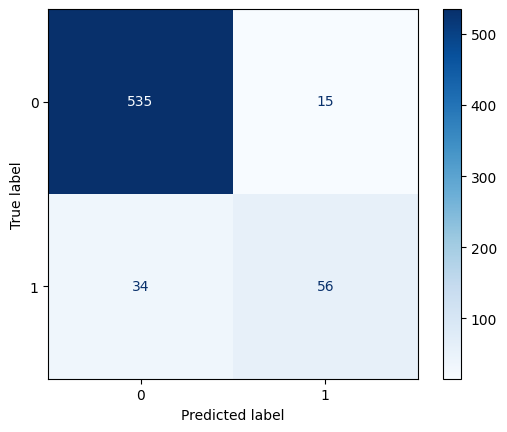

In [59]:
def plot_confusion_matrix(y_true, y_pred, classes):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plotting the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues')
    plt.show()


plot_confusion_matrix(y_test, y_pred, best_model.classes_)

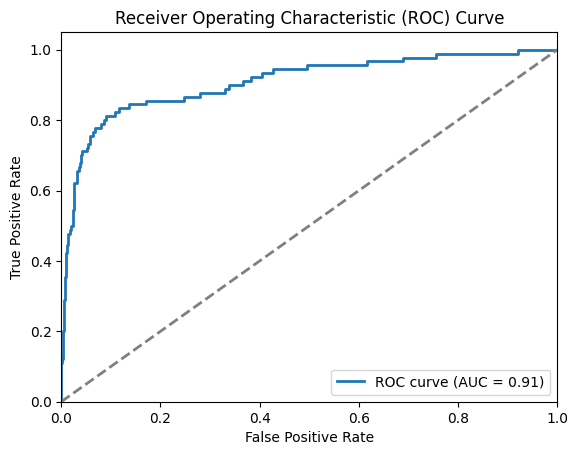

In [60]:
# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### Balancing (Under Sampling)

In [61]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

In [62]:
# Redefining pipeline to train in the resampled data
# Defining the features to be used in the pipeline
numeric_features = ['transaction_amount', 'avg_amount', 'avg_amount_merchant']

categorical_features = ['device_id', 'merchant_id', 'user_id', 'device_missing']

cyclic_features = ['weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']

# Creating a transformer for feature engineering
feature_engineering_transformer = FunctionTransformer(
    lambda df: FeatureEngineering(df.copy()).apply_all_transformations(), validate=False
)

# Preprocessing pipelines for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1.)),
])

# Combining the preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough')

# Creating a pipeline with the feature engineering and preprocessing steps
pipeline = Pipeline(steps=[
    ('engineering', feature_engineering_transformer),
    ('preprocessing', preprocessor)
])

X_train_transformed = pipeline.fit_transform(X_train_resampled)
X_test_transformed = pipeline.transform(X_test)

In [63]:
# Instantiate the model
model_xgb_balanced = XGBClassifier(random_state=42)

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 1, 5]
}

# Start the grid
search_balanced = RandomizedSearchCV(
    model_xgb_balanced,
    param_distributions=params,
    scoring=f1_scorer_classe_1,
    n_jobs=-1,
    cv=5,
    verbose=1,
    n_iter=500
)

# Fit the grid
search_balanced.fit(X_train_transformed, y_train_resampled)

# Get the best model
best_model_balanced = search_balanced.best_estimator_
print("Best parameters found: ", search_balanced.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best parameters found:  {'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5}


In [64]:
# Training model
best_model_balanced.fit(X_train_transformed, y_train_resampled)
y_pred = best_model.predict(X_test_transformed)

# Evaluating the model
print(classification_report(y_test, y_pred))

print("-"*50)

# ROC AUC
y_pred_proba = best_model.predict_proba(X_test_transformed)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       550
           1       0.71      0.30      0.42        90

    accuracy                           0.88       640
   macro avg       0.80      0.64      0.68       640
weighted avg       0.87      0.88      0.86       640

--------------------------------------------------
ROC AUC: 0.8761


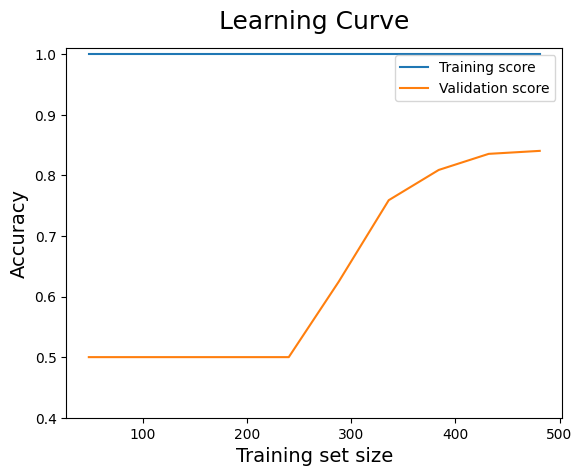

In [65]:
plot_learning_curve(X_train_transformed, y_train_resampled, best_model_balanced, [.4, 1.01])

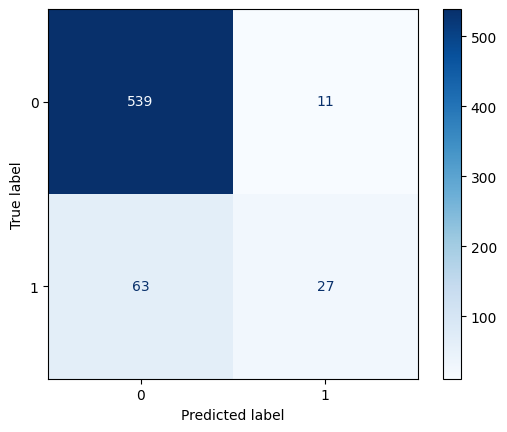

In [66]:
plot_confusion_matrix(y_test, y_pred, best_model_balanced.classes_)

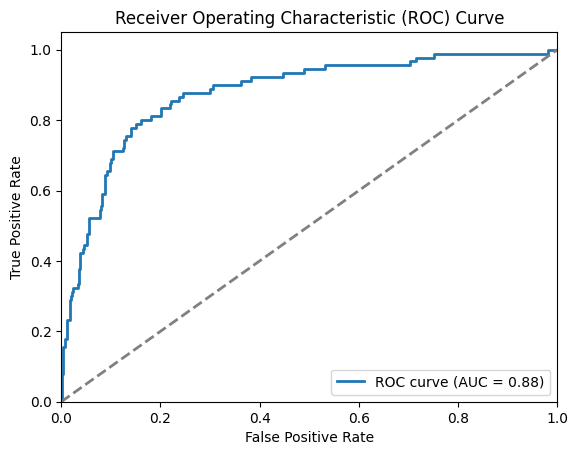

In [67]:
# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Predicting with new data

In [68]:
# Predicting a single transaction

new_data = {
  "transaction_id" : 2342357,
  "merchant_id" : 29744,
  "user_id" : 97051,
  "card_number" : "434505******9116",
  "transaction_date" : "2019-11-30T23:16:32.812632",
  "transaction_amount" : 373.,
  "device_id" : 285475.
}

In [69]:
class PreparePredict:
    """
    A class to prepare data and make fraud predictions using a machine learning model.

    Attributes:
        pipeline (Pipeline): A scikit-learn pipeline for data transformation.
        best_model (BaseEstimator): A trained machine learning model for fraud prediction.
    """

    def __init__(self, pipeline: Pipeline, best_model: BaseEstimator, new_data: dict):
        """
        Initializes the PreparePredict class with a pipeline and a trained model.

        Args:
            pipeline (Pipeline): A scikit-learn pipeline for data transformation.
            best_model (BaseEstimator): A trained machine learning model for fraud prediction.
        """
        self.new_data = new_data
        self.prepared_data = self._prepare_data(new_data)
        self.transaction_id = new_data['transaction_id']
        self.pipeline = pipeline
        self.best_model = best_model

    def _prepare_data(self, new_data: dict) -> pd.DataFrame:
        """
        Prepares the input data for prediction by converting it into a DataFrame and performing necessary transformations.

        Args:
            new_data (dict): A dictionary containing the new data to be prepared.

        Returns:
            pd.DataFrame: A DataFrame containing the prepared data.
        """
        new_data = pd.DataFrame([new_data])
        new_data.drop(columns=['card_number'], inplace=True, errors='ignore')  # Ignora se a coluna não existir
        new_data['transaction_date'] = pd.to_datetime(new_data['transaction_date'], format="%Y-%m-%dT%H:%M:%S.%f")
        return new_data

    def predict_fraud(self) -> int:
        """
        Predicts whether a transaction is fraudulent.

        Args:
            new_data (dict): A dictionary containing the new data to be predicted.

        Returns:
            int: The predicted class (0 for not fraudulent, 1 for fraudulent).
        """
        transformed_data = self.pipeline.transform(self.prepared_data)
        prediction = self.best_model.predict(transformed_data)
        return prediction

    def predict_fraud_proba(self) -> float:
        """
        Predicts the probability that a transaction is fraudulent.

        Args:
            new_data (dict): A dictionary containing the new data to be predicted.

        Returns:
            float: The probability of the transaction being fraudulent.
        """
        transformed_data = self.pipeline.transform(self.prepared_data)
        prediction = self.best_model.predict_proba(transformed_data)
        return prediction.max()  # Assuming the positive class is at index 1

    def mapping_prediction(self, prediction: int) -> dict:
        """
        Maps the prediction to a human-readable response.

        Args:
            prediction (int): The predicted class (0 for not fraudulent, 1 for fraudulent).

        Returns:
            dict: A dictionary containing the transaction ID and the prediction result.
        """
        if prediction[0] == 0:
            return {
                "transaction_id": self.transaction_id,
                "prediction": "approved"
            }
        return {
            "transaction_id": self.transaction_id,
            "prediction": "denied"
        }


In [70]:
start_time = time.time()
preparer = PreparePredict(pipeline, best_model, new_data)
prediction = preparer.predict_fraud()
prediction_proba = preparer.predict_fraud_proba()
result = preparer.mapping_prediction(prediction)
end_time = time.time()

In [71]:
print("Prediction:", prediction)
print("Prediction Probability:", prediction_proba)
print("Result:", result)
print(f"Time to run: {round((end_time - start_time), 4)} seconds")

Prediction: [0]
Prediction Probability: 0.99604195
Result: {'transaction_id': 2342357, 'prediction': 'approved'}
Time to run: 0.0344 seconds


### Rule-Based Approach

This algorithm classifies the risk of a transaction based on a set of predefined rules. \
The algorithm create a score and reprove the transaction based on this score, if the score is greater or equal to 3, reproves the transaction. \
Below is a summary of the rules:
1. **Transaction Amount**
   - **High Risk**: If the transaction amount is more than 3 standard deviations above the user's average. (+3)
   - **Medium Risk**: If the transaction amount is more than 2 standard deviations above the user's average. (+2)
   - **Low Risk**: If the transaction amount is more than 1 standard deviation above the user's average. (+1)

2. **Fraud History**
   - **Medium Risk**: If the user or the card used in the transaction has a history of fraud. (+2)

3. **Device Usage**
   - **Low Risk**: If the user has used more than one device for transactions. (+1)

4. **Sequential Transactions**
   - **Medium Risk**: If the user has made multiple transactions in quick succession (less than 1 hour apart). (+2)

5. **Transaction Time**
   - **Low Risk**: If the transaction occurs after 9 PM (21:00) and the amount is more than 2 standard deviations above the user's average. (+1)

6. **Card Fraud History**
   - **Medium Risk**: If the card used in the transaction has a history of fraud. (+2)

Risk Classification
- **Low Risk**: If none of the above rules are triggered or only low-risk rules are triggered.
- **Medium Risk**: If medium-risk rules are triggered.
- **High Risk**: If high-risk rules are triggered.

Output
- If the risk is **Low**, the recommendation is `"approve"`.
- If the risk is **Medium** or **High**, the recommendation is `"deny"`.

This rule-based approach ensures that transactions are evaluated based on multiple factors, providing a robust risk assessment.

In [72]:

class TransactionRiskClassifier:
    def __init__(self, historical_transactions):
        """
        Initializes the classifier with the historical transactions DataFrame.

        Args:
            historical_transactions (pd.DataFrame): DataFrame containing historical transaction data.
        """
        self.historical_transactions = historical_transactions
        self.score = 0  # Initialize risk score

        # Ensure the 'has_cbk' column exists
        if 'has_cbk' not in self.historical_transactions.columns:
            self.historical_transactions['has_cbk'] = False

    def _evaluate_amount_based_risk(self, transaction_amount, user_transactions):
        """
        Evaluates risk based on the transaction amount compared to the user's historical transactions.

        Args:
            transaction_amount (float): Amount of the current transaction.
            user_transactions (pd.DataFrame): Historical transactions of the user.

        Updates:
            self.score: Adds points based on the transaction amount's deviation from the user's average.
        """
        mean_amount = user_transactions['transaction_amount'].mean()
        std_amount = user_transactions['transaction_amount'].std()

        if transaction_amount > mean_amount + 3 * std_amount:
            self.score += 3
        elif transaction_amount > mean_amount + 2 * std_amount:
            self.score += 2
        elif transaction_amount > mean_amount + 1 * std_amount:
            self.score += 1

    def _evaluate_fraud_history_risk(self, user_id, card_number):
        """
        Evaluates risk based on the user's and card's fraud history.

        Args:
            user_id (int): ID of the user making the transaction.
            card_number (str): Card number used in the transaction.

        Updates:
            self.score: Adds points if the user or card has a history of fraud.
        """
        if user_id in self.historical_transactions[self.historical_transactions['has_cbk']]['user_id'].unique():
            self.score += 2
        if card_number in self.historical_transactions[self.historical_transactions['has_cbk']]['card_number'].unique():
            self.score += 2

    def _evaluate_device_based_risk(self, user_transactions):
        """
        Evaluates risk based on the number of devices used by the user.

        Args:
            user_transactions (pd.DataFrame): Historical transactions of the user.

        Updates:
            self.score: Adds points if the user has used more than one device.
        """
        if len(user_transactions['device_id'].unique()) > 1:
            self.score += 1

    def _evaluate_sequential_transaction_risk(self, user_transactions):
        """
        Evaluates risk if the user is making sequential transactions in a short time.

        Args:
            user_transactions (pd.DataFrame): Historical transactions of the user.

        Updates:
            self.score: Adds points if the user has made transactions in quick succession.
        """
        user_transactions_sorted = user_transactions.sort_values(by='transaction_date')
        time_diff = user_transactions_sorted['transaction_date'].diff().dt.total_seconds()
        if any(time_diff < 1800):  # If there are transactions less than 1 hour apart
            self.score += 2

    def _evaluate_time_based_risk(self, transaction_time, transaction_amount, mean_amount, std_amount):
        """
        Evaluates risk if the transaction occurs late at night and has a high amount.

        Args:
            transaction_time (datetime.time): Time of the transaction.
            transaction_amount (float): Amount of the transaction.
            mean_amount (float): Average transaction amount of the user.
            std_amount (float): Standard deviation of the user's transaction amounts.

        Updates:
            self.score: Adds points if the transaction is late at night and has a high amount.
        """
        if (transaction_time.hour >= 21 or transaction_time.hour < 3):
            self.score += 1

    def classify_risk(self, new_transaction):
        """
        Classifies the risk of a new transaction based on predefined rules.

        Args:
            new_transaction (dict): Dictionary containing details of the new transaction.

        Returns:
            dict: Dictionary with transaction_id and recommendation ("approve" or "deny").
        """
        # Reset score for each new transaction
        self.score = 0

        # Extract transaction details
        user_id = new_transaction['user_id']
        transaction_amount = new_transaction['transaction_amount']
        transaction_date = new_transaction['transaction_date']
        card_number = new_transaction['card_number']

        # Get user's historical transactions
        user_transactions = self.historical_transactions[self.historical_transactions['user_id'] == user_id]
        mean_amount = user_transactions['transaction_amount'].mean()
        std_amount = user_transactions['transaction_amount'].std()

        # Evaluate each risk factor
        self._evaluate_amount_based_risk(transaction_amount, user_transactions)
        self._evaluate_fraud_history_risk(user_id, card_number)
        self._evaluate_device_based_risk(user_transactions)
        self._evaluate_sequential_transaction_risk(user_transactions)

        # Convert transaction_date to string if it's a Timestamp
        if isinstance(transaction_date, pd.Timestamp):
            transaction_date_str = transaction_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
        else:
            transaction_date_str = transaction_date

        # Parse the string to datetime.time
        transaction_time = datetime.strptime(transaction_date_str, "%Y-%m-%dT%H:%M:%S.%f").time()

        # Evaluate time-based risk
        self._evaluate_time_based_risk(transaction_time, transaction_amount, mean_amount, std_amount)

        # Determine recommendation based on score
        if self.score >= 5:
            recommendation = "deny"
            risk_level = "high"

        elif self.score >= 3:
            recommendation = "deny"
            risk_level = "medium"
        else:
            recommendation = "approve"
            risk_level = "low"

        return {
            "transaction_id": new_transaction['transaction_id'],
            "recommendation": recommendation
        }, {"risk_level" : risk_level}

# Function to evaluate the model
def evaluate_model(classifier, historical_transactions):
    """
    Evaluates the performance of the TransactionRiskClassifier using the historical transactions.

    Args:
        classifier (TransactionRiskClassifier): An instance of the classifier.
        historical_transactions (pd.DataFrame): DataFrame containing historical transactions with labels.

    Returns:
        dict: A dictionary containing accuracy, precision, recall, and F1-score.
    """
    # List to store predictions and true labels
    predictions = []
    true_labels = []

    # Iterate over each transaction in the DataFrame
    for _, transaction in historical_transactions.iterrows():
        # Classify the transaction
        result, _1 = classifier.classify_risk(transaction.to_dict())
        recommendation = result['recommendation']

        # Map recommendation to binary label (1 for "deny", 0 for "approve")
        predicted_label = 1 if recommendation == "deny" else 0

        # Get the true label from the DataFrame
        true_label = 1 if transaction['has_cbk'] else 0

        # Append to lists
        predictions.append(predicted_label)
        true_labels.append(true_label)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

In [73]:
# Evaluating in the historical transactions

df = pd.DataFrame(data)

# Create an instance of the classifier
classifier = TransactionRiskClassifier(df)

# Evaluate the model
metrics = evaluate_model(classifier, df)

# Print the metrics
print("Model Metrics:")
print(f"Accuracy: {metrics['accuracy']:.2f}")
print(f"Precision: {metrics['precision']:.2f}")
print(f"Recall: {metrics['recall']:.2f}")
print(f"F1-Score: {metrics['f1_score']:.2f}")

Model Metrics:
Accuracy: 0.96
Precision: 0.78
Recall: 1.00
F1-Score: 0.87


In [74]:
# New transaction to classify
new_transaction = {
    "transaction_id": 2342357,
    "merchant_id": 29744,
    "user_id": 97051,
    "card_number": "434505******9116",
    "transaction_date": "2019-11-30T23:16:32.812632",
    "transaction_amount": 373,
    "device_id": 285475
}

# Create an instance of the classifier
classifier = TransactionRiskClassifier(df)

# Classify the transaction
output, risk_level = classifier.classify_risk(new_transaction)

print(output)
print(risk_level)

{'transaction_id': 2342357, 'recommendation': 'approve'}
{'risk_level': 'low'}


## Answers

### Suspecious behaviors, conlusions, actions.

This analysis identified behavioral patterns in chargeback fraud transactions using the provided dataset.

**Suspicious behaviors**:

  * **Transaction Amount**:
    - The `transaction_amount` column had the highest correlation with fraud (**0.29**).  
    - Fraudulent transactions had significantly higher average ($1453.5$) and median ($999.47$) values compared to all transactions ($767.8$ and $415.9$).  
    - Standard deviation increased from $889.1$ to $1169.5$, indicating greater variance and possible “test” transactions.  
    - Fraud probability increased with transaction amount.

  * **Users**:
    - Some of the most active users also had the highest fraud rates.  
    - 120 users had 100% of their transactions marked as fraudulent.  
    - A high fraud rate was observed for users making frequent transactions within short time frames (e.g., 81% fraud rate for two transactions within 15 minutes).

  * **Merchants**:
    - Certain merchants had high fraudulent transaction rates, suggesting security issues or potential fraudulent involvement.

  * **Devices**:
    - Only 7% (130 out of 1996) of devices had a fraud history.  
    - Users with multiple devices showed a significantly higher fraud rate.

  * **Cards**:
    - 9% (274 out of 2925) of credit cards had a fraud history, following a similar pattern to devices.

  * **Time-Based Patterns**
    - Fraudulent transactions peaked between Thursday and Sunday.  
    - Peak transaction hours were 6 PM to 9 PM, aligning with fraud trends.  
    - The fraud rate increased from 6 PM to 2 AM, exceeding the total transaction growth rate.

**Possible actions**:

* **Requiring More Security Measures / Blocking Transactions Following a Rule-Based Approach**, for example:
    - **User-Oriented Threshold for Limiting Transactions**: Apply a threshold value like median + 1 standard deviation (I'ts an example, but I suggested other options in the EDA -> Summary).
    - Flag users, cards, or devices with previous fraudulent behavior.
    - Flag transactions whose value deviates significantly from the merchant's usual (median + 1 standard deviation).
    - Monitor users making multiple transactions in a short time frame.

* **User Behavior Analysis**:
    - Identify and analyze patterns in user transaction behaviors.

* **Merchant Monitoring**:
    - Evaluate merchants with high fraudulent transaction rates to detect security issues or potential fraud involvement.

* **Device and Card Control**:
    - Apply additional verification for users with multiple devices, as they tend to have higher fraud rates.
    - Implement a blacklist for credit cards that have a history of fraudulent transactions.

* **Machine Learning for Fraud Detection**:
    - Develop a predictive model based on identified fraud patterns to automatically block or flag suspicious transactions.
    - Integrate user behavior analysis, fraud history, and time-based trends to improve fraud detection accuracy.



### Additional data would be valuable for identifying patterns of potential fraudulent behavior.

**Geographical and IP Address Anomalies**:
  - If a user suddenly makes a transaction from a country or region far from their usual location, it could be a sign of account takeover.
  - Geolocation tracking and flagging inconsistent activity (e.g., logging in from the U.S. and then transacting from Europe minutes later) can help prevent fraud.
  - Multiple Transactions from Different Locations in a Short Time

**Service/Product bought in the transaction**:
  - Analyzing the type of service or product purchased in fraudulent transactions can help detect patterns of fraud.
  - Identifying anomalies such as a sudden shift in the types of products purchased.
  - Tracking which products/services are associated with higher fraud rates can inform the development of more targeted fraud prevention measures.


### Suggestions to prevent frauds and/or chargebacks.

* Keep the data team consistently working together to enhance the fraud prevention process.
* Continuously feed and improve the prediction model.
* Understand the patterns of customers and vendors registered on the platform.
* Clearly define, using rule-based methods, what qualifies as a high-risk transaction.
* Maintain records and restrict devices, cards, or users with a history of fraud (using a blacklist method or additional authentication for suspicious transactions).
* Stay updated on techniques and methods used by fraudsters.
* Predicting and preventing fraud are complex challenges, almost like a cat-and-mouse game, so it's essential to remain calm.